# Find orientation of the board and calculate absolute vertical acceleration

In [67]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.basemap import Basemap

import pandas as pd
import numpy as np
import scipy

from scipy import stats
from scipy import constants
from scipy import signal #added
from scipy.signal import butter, lfilter
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.integrate import simps
from scipy.integrate import cumtrapz

import os
import datetime
import pytz
import re

import peakutils
import statsmodels.api as sm

import requests

import mpld3
import folium
#import cmocean
import skinematics as skin
from skinematics import quat, vector, misc, rotmat, imus, view
import pygame

from plotly import tools #added all the plotly's
import plotly.offline
import plotly.graph_objs as go

import math #added
import re   #added

# For the definition of the abstract base class IMU_Base
import abc

import sys

#%matplotlib qt
#%matplotlib notebook
%matplotlib inline
#import cmocean
print("Done!")

Done!


### Ride list
Create a list of ride (session) identifiers manually (looking at surf.smartfin.org and known fin identifiers).

In [68]:
ride_ids = ['14827']
# 13735 - One of Phil's Smartfin Surf Session Rides
# 14743 - Motion Control July 10th
# 14750 - Magnetometer Control July 11th
# 14814 - Pool Displacement Control July 17th
# 14815 - Compass Orientation (Lying on Charger Side) July 19th (4Hz data at MESOM Lab)
# 14816 - Compass Orientation (Lying with LED down) July 20th (30Hz data at CSE UCSD)
# 14827 - Pool Displacement Control July 23rd (30Hz at CSE UCSD)
# 14840 - MESOM Parking Lot Static Rotation Combined Tracking (30Hz)
# 14865 - Martz Lab Rotation Vertical Component Manual Test (30Hz)
# 14888 - CDIP Buoy Calibration Run #1 July 30 (Fin in vertical position, pointing upwards)
# 14893 and 14894 - Junk files to drain battery (stationary tests an hour long at constant 30Hz)
# 14902 - Junk data when fin accidentally turn on while walking to beach for magneto calibration
# 14903 - Beach magnetometer calibration (y-x plane (horizontal or yaw) rotation of surfboard frame) August 3rd
# 14904 - Beach magnetometer calibration (x-z plane (lengthwise or pitch) rotation of surfboard frame) August 3rd
# 14905 - Beach magnetometer calibration (y-z plane (crosswise or roll) rotation of surfboard frame) August 3rd
# 15138 - Scripps Pier FLoat Session (~15-20 minutes long of floating by the pier with fin in board) August 20th
print("Ride",ride_ids,"loaded up.")

Ride ['14827'] loaded up.


In [69]:
#%% Fin ID scraper
# Input fin ID, get all ride IDs
# base URL to which we'll append given fin IDs
fin_url_base = 'http://surf.smartfin.org/fin/'

# Look for the following text in the HTML contents in fcn below
str_id_ride = 'rideId = \'' # backslash allows us to look for single quote
str_id_date = 'var date = \'' # backslash allows us to look for single quote

#%% Ride ID scraper
# Input ride ID, get ocean and motion CSVs
# Base URL to which we'll append given ride IDs
ride_url_base = 'https://surf.smartfin.org/ride/'

# Look for the following text in the HTML contents in fcn below
str_id_csv = 'img id="temperatureChart" class="chart" src="' 

def get_csv_from_ride_id(rid):
    # Build URL for each individual ride
    ride_url = ride_url_base+str(rid)
    print(ride_url)
    
    # Get contents of ride_url
    html_contents = requests.get(ride_url).text
    
    # Find CSV identifier 
    loc_csv_id = html_contents.find(str_id_csv)
    
    # Different based on whether user logged in with FB or Google
    offset_googleOAuth = [46, 114]
    offset_facebkOAuth = [46, 112]
    if html_contents[loc_csv_id+59] == 'f': # Facebook login
        off0 = offset_facebkOAuth[0]
        off1 = offset_facebkOAuth[1]
    else: # Google login
        off0 = offset_googleOAuth[0]
        off1 = offset_googleOAuth[1]
        
    csv_id_longstr = html_contents[loc_csv_id+off0:loc_csv_id+off1]
    
#    print(csv_id_longstr)
    
    # Stitch together full URL for CSV
    if ("media" in csv_id_longstr) & ("Calibration" not in html_contents): # other junk URLs can exist and break everything
        
        ocean_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Ocean.CSV'
        motion_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Motion.CSV'
        
        print(ocean_csv_url)
        # Go to ocean_csv_url and grab contents (theoretically, a CSV)
        ocean_df_small = pd.read_csv(ocean_csv_url, parse_dates = [0])
        elapsed_timedelta = (ocean_df_small['UTC']-ocean_df_small['UTC'][0])
        ocean_df_small['elapsed'] = elapsed_timedelta/np.timedelta64(1, 's')
        
        motion_df_small = pd.read_csv(motion_csv_url, parse_dates = [0])
        
        # Reindex on timestamp if there are at least a few rows
        if len(ocean_df_small) > 1:
            ocean_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            motion_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            
            print(ocean_df_small)
            
            
            #May need to change this sampling interval:
            sample_interval = '33ms'
            
            
            ocean_df_small_resample = ocean_df_small.resample(sample_interval).mean()
            motion_df_small_resample = motion_df_small.resample(sample_interval).mean()
            
            # No need to save many extra rows with no fix
            motion_df_small = motion_df_small[~np.isnan(motion_df_small.Latitude)]
            
            return ocean_df_small_resample, motion_df_small_resample

    else:
        ocean_df_small_resample = pd.DataFrame() # empty DF just so something is returned
        motion_df_small_resample = pd.DataFrame() 
        return ocean_df_small_resample, motion_df_small_resample
print("Done.")

Done.


In [70]:
appended_ocean_list = [] # list of DataFrames from original CSVs
appended_motion_list = []
appended_multiIndex = [] # fin_id & ride_id used to identify each DataFrame

## Nested loops (for each fin ID, find all ride IDs, then build a DataFrame from all ride CSVs)
## (Here, ride IDS are either ocean or motion dataframes)
count_good_fins = 0
    
# Loop over ride_ids and find CSVs
for rid in ride_ids:
    try:
        new_ocean_df, new_motion_df = get_csv_from_ride_id(rid) # get given ride's CSV from its ride ID using function above
        #print(len(new_ocean_df))
        #print(len(new_motion_df))
        if not new_ocean_df.empty: # Calibration rides, for example
            # Append only if DF isn't empty. There may be a better way to control empty DFs which are created above
            appended_multiIndex.append(str(rid)) # build list to be multiIndex of future DataFrame
            appended_ocean_list.append(new_ocean_df)
            appended_motion_list.append(new_motion_df)
            print("Ride data has been uploaded.")
            #print("Ride: ", rid, "data has been uploaded.")
            count_good_fins += 1
        
    except: 
        print("Ride threw an exception!")
        #print("Ride ", rid, "threw an exception!")    

#%% Build the "Master" DataFrame

# appended_ocean_df.summary()
df_keys = tuple(appended_multiIndex) # keys gotta be a tuple, a list which data in it cannot be changed
ocean_df = pd.concat(appended_ocean_list, keys = df_keys, names=['ride_id'])
motion_df = pd.concat(appended_motion_list, keys = df_keys, names = ['ride_id'])


##Here, maybe just use info from the motion_df and don't worry about ocean_df data for now.
##If you do want ocean_df data, look at how Phil was getting it from "July 10th and 11th Calibration" jupyter notebook file.
#print(motion_df)


https://surf.smartfin.org/ride/14827
https://surf.smartfin.org/media/201807/google_117589279598321562176_000666D321BE_180723164430_Ocean.CSV
                               Time  Temperature 1  Calibrated Temperature 1  \
UTC                                                                            
2018-07-23 16:44:42.467  1370665472            493                    30.812   
2018-07-23 16:44:48.487  1370671492            496                    31.000   
2018-07-23 16:44:54.507  1370677512            499                    31.188   
2018-07-23 16:45:00.528  1370683533            500                    31.250   
2018-07-23 16:45:06.549  1370689554            500                    31.250   
2018-07-23 16:45:12.569  1370695574            502                    31.375   
2018-07-23 16:45:18.591  1370701596            502                    31.375   
2018-07-23 16:45:24.612  1370707617            504                    31.500   
2018-07-23 16:45:30.634  1370713639            505         

## Make a copy of the original motion_df dataframe

In [71]:
#print(motion_df)

saved_copy_motion_df = motion_df.copy(deep=True) #make a copy of the dataframe with raw data

print(saved_copy_motion_df)

                                         Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
14827   2018-07-23 16:44:42.915  1.370666e+09   138.0  -380.0   333.0 -1115.0   
        2018-07-23 16:44:42.948  1.370666e+09   181.0  -459.0   225.0  -720.0   
        2018-07-23 16:44:42.981  1.370666e+09   108.0  -446.0   291.0  -976.0   
        2018-07-23 16:44:43.014  1.370666e+09   133.0  -401.0   275.0  -558.0   
        2018-07-23 16:44:43.047  1.370666e+09   153.0  -415.0   101.0  -799.0   
        2018-07-23 16:44:43.080  1.370666e+09    46.0  -435.0   307.0  -760.0   
        2018-07-23 16:44:43.113  1.370666e+09   243.0  -324.0   412.0  -247.0   
        2018-07-23 16:44:43.146  1.370666e+09   281.0  -382.0   311.0   -69.0   
        2018-07-23 16:44:43.179  1.370666e+09   217.0  -412.0   135.0   323.0   
        2018-07-23 16:44:43.212  1.370666e+09   341.0  -546.0    56.0   190.0   
        2018-07-23 16:44:43.

## Calcualting time_elapsed, time_offsets and creating raw data lists for IMU measurements

In [72]:
#Reading data from ride_ids = ['xxxxx']
#The name of the motion dataframe is: motion_df

#Get times from the "Time" column to create time_o_list and time_e_list.
#Get imus from the "IMU A[*]" column to create the imu acc arrays. 

#Drop the "nan" values from the columns that we care about. 
dropped_motion_df = motion_df.dropna(subset=['Time', 'IMU A1', 'IMU A2', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3', 'IMU M1', 
                                            'IMU M2', 'IMU M3'])
#Can test that this works by printing this one:
#dropped_motion_df = motion_df.dropna(subset=['Time', 'IMU A1', 'IMU A2', 'IMU A3', 'Latitude'])
#print(dropped_df)

time_e_list = []
time_o_list = []

#Remove all nan instances in time:
time_array_nans = np.array(dropped_motion_df.loc[:,"Time"], dtype=float)
time_array = []
imuA1_array_nans = np.array(dropped_motion_df.loc[:,"IMU A1"], dtype=float)
imu_array_A1 = []
imuA2_array_nans = np.array(dropped_motion_df.loc[:,"IMU A2"], dtype=float)
imu_array_A2 = []
imuA3_array_nans = np.array(dropped_motion_df.loc[:,"IMU A3"], dtype=float)
imu_array_A3 = []
imuG1_array_nans = np.array(dropped_motion_df.loc[:,"IMU G1"], dtype=float)
imu_array_G1 = []
imuG2_array_nans = np.array(dropped_motion_df.loc[:,"IMU G2"], dtype=float)
imu_array_G2 = []
imuG3_array_nans = np.array(dropped_motion_df.loc[:,"IMU G3"], dtype=float)
imu_array_G3 = []
imuM1_array_nans = np.array(dropped_motion_df.loc[:,"IMU M1"], dtype=float)
imu_array_M1 = []
imuM2_array_nans = np.array(dropped_motion_df.loc[:,"IMU M2"], dtype=float)
imu_array_M2 = []
imuM3_array_nans = np.array(dropped_motion_df.loc[:,"IMU M3"], dtype=float)
imu_array_M3 = []

#Get all the times and imus where time, imu a1, imu a2, and imu a3 are NOT nan values:
for t,x,y,z,a,b,c,d,e,f in zip(time_array_nans, imuA1_array_nans, imuA2_array_nans, imuA3_array_nans, imuG1_array_nans, 
                              imuG2_array_nans, imuG3_array_nans, imuM1_array_nans, imuM2_array_nans, imuM3_array_nans):
    if (np.isnan(t)==0 and np.isnan(x)==0 and np.isnan(y)==0 and np.isnan(z)==0):
        time_array.append(t)
        imu_array_A1.append(x)
        imu_array_A2.append(y)
        imu_array_A3.append(z)
        imu_array_G1.append(a)
        imu_array_G2.append(b)
        imu_array_G3.append(c)
        imu_array_M1.append(d)
        imu_array_M2.append(e)
        imu_array_M3.append(f)

#for x in time_array:
#    print(x)
    
start_time = time_array[0]
time_len = len(time_array)
    
i = 0
while (i < time_len - 1):
    prev = time_array[i]
    after = time_array[i+1]
    offset = after - prev
    #if (np.isnan(offset)==0):
    time_o_list.append(offset)
    
    elapsed = time_array[i] - start_time
    #if (np.isnan(elapsed)==0):
    time_e_list.append(elapsed)
    
    i = i + 1

##Check to make sure there are no "nan" values:
i = 0
while (i < len(time_o_list)):
    if (np.isnan(time_o_list[i])):
        print("Error! Value at index: ", i, " is nan")
    i = i + 1

#Drop the last value from each of the imu lists to make it match the time list.
del(imu_array_A1[-1])
del(imu_array_A2[-1])
del(imu_array_A3[-1])
del(imu_array_G1[-1])
del(imu_array_G2[-1])
del(imu_array_G3[-1])
del(imu_array_M1[-1])
del(imu_array_M2[-1])
del(imu_array_M3[-1])
    
#print(len(time_e_list))
#print(len(time_o_list))
#print(len(imu_array_A1))
#print(len(imu_array_A2))
#print(len(imu_array_A3))
#print(len(imu_array_G1))
#print(len(imu_array_G2))
#print(len(imu_array_G3))
#print(len(imu_array_M1))
#print(len(imu_array_M2))
#print(len(imu_array_M3))
print("Done.")

Done.


## Convert raw units to actual units (acc to [m/s^2]), g to [deg/s], and (time to [s])

In [73]:
## Convert raw units to actual units (acc to [m/s^2]) and (time to [s])
#Raw acceleration constant 512 = 1g (accelerometer's measured force due to gravity)
g_const = 512
gyro_const = 8.2      # Raw gyrscope constant 8.2 bits per degree

gravity = 9.80665     # Approximate measurement for gravity

# Correct the IMU Acceleration columns into units of meters
# Dividing by 512 is equivalent to muliplying by 4 to correct the bit shifting by 2 places and dividing by 2048 to convert bits to G's
# Multiplying by the 9.81 afterwards is simply to convert G's into m/s^2

def convert_acc_units(acc_array):
    ret_array = []
    for a in acc_array:
        #Acceleration is now in m/s^2, need to subtract gravity from vertical axis. (??) --> Not yet, we'll do it later on
        new_a = a / g_const * gravity# - gravity
        ret_array.append(new_a)
    return ret_array

imuA1_array = convert_acc_units(imu_array_A1) #new units in m/s^2
imuA2_array = convert_acc_units(imu_array_A2) #new units in m/s^2
imuA3_array = convert_acc_units(imu_array_A3) #new units in m/s^2

##To check:
#for x,y in zip(imuA2_array, imu_array_A2):
    #print(x,y)
    
def convert_gyr_units(gyr_array):
    ret_array = []
    for g in gyr_array:
        # Gyroscopic Rotation converts to deg/s
        new_g = g / gyro_const
        ret_array.append(new_g)
    return ret_array

imuG1_array_not_cal = convert_gyr_units(imu_array_G1) #new units in deg/s (will need to be rads for some later functions)
imuG2_array_not_cal = convert_gyr_units(imu_array_G2)
imuG3_array_not_cal = convert_gyr_units(imu_array_G3)

#To check:
#for x,y in zip(imuG2_array, imu_array_G2):
    #print(x,y)
    
    
def convert_time_units(time_array):
    ret_array = []
    for t in time_array:
        new_t = t * (10**(-3)) #converting units in milliseconds to seconds
        ret_array.append(new_t)
    return ret_array

time_o_array = convert_time_units(time_o_list) #new units in seconds
time_e_array = convert_time_units(time_e_list) #new units in seconds

##To check:
#for t in time_e_array:
#    print(t)

print(len(time_e_array))
print(len(time_e_list))
print(len(imuA2_array))

#plt.plot(time_e_array, imuA2_array)
#plt.show()
#print("Gyro_plot:")
#plt.plot(time_e_array, imuG2_array)
#plt.show()

#print("Why are the y-axis values so small?")

23432
23432
23432


## Calibrating Gyroscope Sensors with Adaptive Moving Window
Gyroscopes can easily be statically calibrated. We have to detect when the fin is motionless by looking at when the deltas in gyroscope readings are very small. When the fin is not moving much, this will start a windowed average that will search until the delta is no longer under the threshold. It must find a minimum of 7 consecutive motionless deltas (about 1/5 of a second) in order to calibrate the data. It then uses this calibration to calibrate all of the points until a new calibration constant is found, in which it starts using the new constant from where the new average was started.

In [74]:
def adaptive_gyroscope_calibration(gyr, thresh):
    # Takes in gyroscope array [1xN] and a threshold value in deg/s
    print("The current threshold value is:",thresh)       # Prints the threshold
    ret_array = gyr.copy()                            # Initialize the calibrated return array (which will be calibrated and returned)
    calibration_constant = 0                              # Initialize loop variables
    last_touched_value = 0
    calibration_was_attempted = 0
    current = 0
    #calibrations_completed = 0
    calarray_pos = np.zeros(shape=(500,1))                  #Initialize an array to store calibration constant positions in (made excessively large for longer sessions)
    calarray_constants = np.zeros(shape=(500,1))            #Initialize an array to store calibration constant values
    print("Total rows of data:", len(gyr))
    
    calibration_was_attempted = 0     # Reset all state variables
    last_touched_value = 0
    calibrations_completed = 0
    current = 0                       # Reset iterator
    while current < len(gyr) - 100:
    #for current in range(len(gyr)):
        calibration_was_attempted = 0                 #Reset the state of calibration attempted
        curr_pos = gyr[current]
        next_pos = gyr[current+1]
        difference = next_pos - curr_pos          #Find the delta between current and next value
        
        if (difference < thresh) and (difference > -1*thresh):   #If the delta is within the threshold:
            calibration_was_attempted = 1                        #Change state: calibration_was_attempted to true
            start_average = current                              #Mark the start of a potential averaging window
            end_average = current+1                              #Initialize the end of a potential averaging window (size 1 to be safe)
            next_seven_fail = 0                                  #Initialize variable to tell if next 7 deltas were within threshold
            end_of_deltas = 0                                    #Initialize variable to tell when delta is no longer within threshold
            final_sev_check_pos = 0                              #Initialize variable to hold marker at the last seven check position
           
            for seven_check in range(7):                                       # Check the next 7 deltas (1/4 second @ 30Hz) to get min window
                sev_check_curr_pos = gyr[current+seven_check+1]
                sev_check_next_pos = gyr[current+seven_check+2]
                sev_check_difference = sev_check_next_pos - sev_check_curr_pos
                if (sev_check_difference > thresh) or (sev_check_difference < -1*thresh):  # If at any point a delta is not within threshold, then stop and start over
                    next_seven_fail = 1                         #Change failure status of seven_check to TRUE
                    final_sev_check_pos = current+seven_check+1
                    last_touched_value = current+seven_check+1  #Update the last_touched_value by the loop
                    break                                       #Break out of the loop and restart
                final_sev_check_pos = current+seven_check+1     #Update the last position in seven_check
                end_average = final_sev_check_pos               #Update the end of the averaging window
                last_touched_value = end_average                #Update the last touched value
            
            if next_seven_fail == 0:                      #If the next seven deltas are within threshold, continue looking for last valid delta (if seven_check failed, then this loop shouldn't run)
                iterator = 0
                while (end_of_deltas == 0) and (not (gyr[final_sev_check_pos+iterator] is None)):
                    #while we haven't found the last valid delta, AND the next value isn't empty/DNE
                    if final_sev_check_pos+iterator+1 >= len(gyr):
                        end_of_deltas = 1
                        end_average = final_sev_check_pos+iterator
                        last_touched_value = end_average
                    else:
                        finding_end_curr_pos = gyr[final_sev_check_pos+iterator]
                        finding_end_next_pos = gyr[final_sev_check_pos+iterator+1]
                        finding_end_difference = finding_end_next_pos - finding_end_curr_pos
                        if (finding_end_difference >= thresh) or (finding_end_difference <= -1*thresh):      #if difference is outside threshold, enter "end found" state
                            end_of_deltas = 1                                     #Set "end found" state to true
                            end_average = final_sev_check_pos+iterator            #Mark ending of window with the last valid delta position
                            last_touched_value = end_average                      #Update the last touched value
                            break
                        iterator += 1
                averaging_pos = start_average
                total_sum = 0
                num_of_nums = 0
                while (averaging_pos < end_average) and (averaging_pos < len(gyr)-1):	#Start averaging the values within the averaging window
                    total_sum += gyr[averaging_pos]
                    num_of_nums += 1
                    averaging_pos += 1
                calibration_constant = total_sum / num_of_nums
                calarray_pos[calibrations_completed] = current #Store calibration start location into an array
                calarray_constants[calibrations_completed] = calibration_constant #Store calibrations into an array
                calibrations_completed += 1
                #print("Start of the average was",start_average)
                #print("Position of the last touched value was",last_touched_value)
                #print("Newest calibration calculated:",calibration_constant)
        if calibration_was_attempted == 1:
            current = last_touched_value     #Assign current to the last value looked at by the loop, to avoid redundant searches
        else:
            current += 1
    
    cal_pos_iterator = 0     # Iterator to point to next upcoming calibration position, so we know when to change calibration value
    for i in range(len(ret_array)):
        if cal_pos_iterator == 0:     # Unique case for setting the first calibration constant
            enforcer = calarray_constants[0]
            cal_pos_iterator = 1
            #cal_value_iterator = 1
            ret_array[i] -= enforcer
        else:
            if i < calarray_pos[cal_pos_iterator] and i < len(ret_array)-1:       # if the current position hasn't reached the start of the next calibration window
                ret_array[i] -= enforcer
            elif i == calarray_pos[cal_pos_iterator] and i < len(ret_array)-1:    # if the current position is at the start of the next calibration window
                enforcer = calarray_constants[cal_pos_iterator]
                cal_pos_iterator += 1
                ret_array[i] -= enforcer
            elif i > calarray_pos[cal_pos_iterator] and i < len(ret_array)-1 and calarray_pos[cal_pos_iterator] == 0:
                ret_array[i] -= enforcer
            else:
                print("Current position skipped unexpectedly past next calibration window.")
                print(i)
                break
    return ret_array


threshold = 5 / 8.2  # Set the threshold that passes to the calibration function
imuG1_array = adaptive_gyroscope_calibration(imuG1_array_not_cal, threshold)
imuG2_array = adaptive_gyroscope_calibration(imuG2_array_not_cal, threshold)
imuG3_array = adaptive_gyroscope_calibration(imuG3_array_not_cal, threshold)


G1_comparison = np.stack((imuG1_array_not_cal, imuG1_array), axis=-1)
print(G1_comparison)
print("Done calibrating.")

The current threshold value is: 0.6097560975609757
Total rows of data: 23432
Current position skipped unexpectedly past next calibration window.
23431
The current threshold value is: 0.6097560975609757
Total rows of data: 23432
Current position skipped unexpectedly past next calibration window.
23431
The current threshold value is: 0.6097560975609757
Total rows of data: 23432
Current position skipped unexpectedly past next calibration window.
23431
[[-135.97560975609758 array([-134.87804878])]
 [-87.8048780487805 array([-86.70731707])]
 [-119.02439024390245 array([-117.92682927])]
 ..., 
 [27.195121951219516 array([ 27.42378049])]
 [-0.9756097560975611 array([-0.74695122])]
 [-8.658536585365855 -8.6585365853658551]]
Done calibrating.


## Center and Calibrate Magnetometer Data 

In [75]:
# Offset variables help in recentering the magnetic data in order to define direction and use trig functions
#     for some calculations. These values were estimated from data collected from multiple tests and hold fairly well.
# Magnetic data is relative, so as long as all of the axis share similar magnitude in value, then data should be fine
M1_offset_var = 219.786
M2_offset_var = 180
M3_offset_var = 280

def calibrate_magn_data(magn_array, offset_value):
    ret_array = []
    for m in magn_array:
        new_m = m - offset_value
        ret_array.append(new_m)
    return ret_array

imuM1_array = calibrate_magn_data(imu_array_M1, M1_offset_var)
imuM2_array = calibrate_magn_data(imu_array_M2, M2_offset_var)
imuM3_array = calibrate_magn_data(imu_array_M3, M3_offset_var)

#print(imu_array_M1)
#print(imuM1_array)
print("Done.")

Done.


## Setting up N x 3 arrays for later functions

In [76]:
# Create N x 3 arrays for functions that need them later on, such as Scikit Kinematics
acc_height = len(imuA1_array)
print(acc_height)
gyr_height = len(imuG1_array)
magn_height = len(imuM1_array)

acc_array = np.zeros(shape=(acc_height,3))
gyr_array = np.zeros(shape=(gyr_height,3))
magn_array = np.zeros(shape=(magn_height,3))

for x in range(len(acc_array)):
    acc_array[x,0] = imuA1_array[x]
    acc_array[x,1] = imuA2_array[x]
    acc_array[x,2] = imuA3_array[x]
#print(acc_array)

for x in range(len(gyr_array)):
    gyr_array[x,0] = imuG1_array[x]
    gyr_array[x,1] = imuG2_array[x]
    gyr_array[x,2] = imuG3_array[x]
#print(gyr_array)

for x in range(len(magn_array)):
    magn_array[x,0] = imuM1_array[x]
    magn_array[x,1] = imuM2_array[x]
    magn_array[x,2] = imuM3_array[x]
#print(magn_array)
print("Done.")

23432
Done.


### Magnetic Data Graphs for Visualization

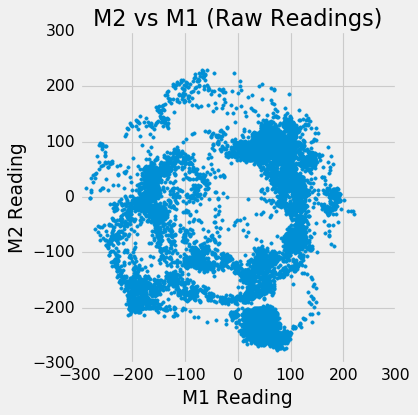

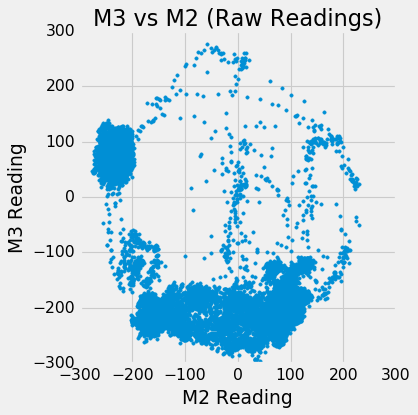

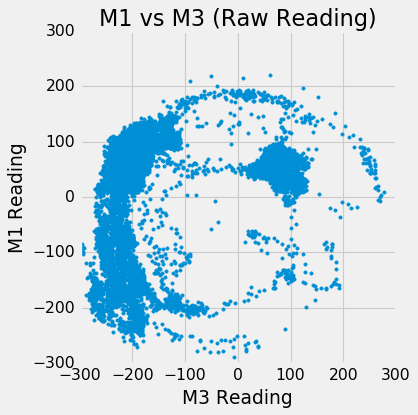

M1 Average value = 29.861106521
M2 Average value = -121.54796859
M3 Average value = -39.4499829293
M1 2.5 standard deviations = 186.266223896
M1 proper range: -156.405117375 to 216.127330417
M2 2.5 standard deviations = 330.636316421
M2 proper range: -452.184285011 to 209.088347831
M3 2.5 standard deviations = 354.03049208
M3 proper range: -393.480475009 to 314.580509151


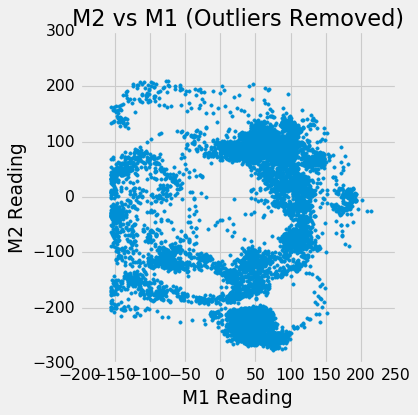

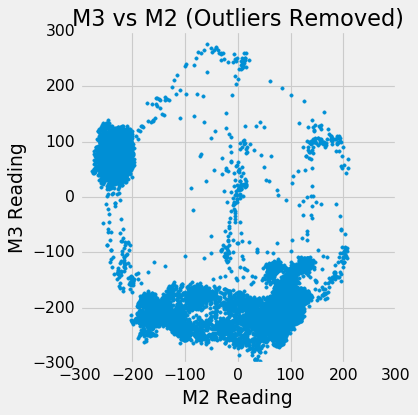

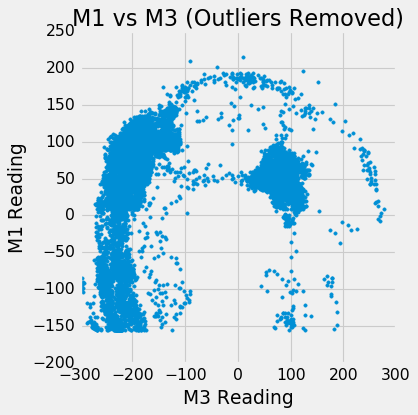

M1 New Average value = 44.0534197099
M2 New Average value = -125.696166265
M3 New Average value = -29.7443721861
Done.


In [77]:
# Set up the plots of magnetometer readings (in fin frame)
plt.style.use('classic')
plt.style.use('fivethirtyeight')

f1 = plt.figure(figsize=(10,5))
f2 = plt.figure(figsize=(10,5))
f3 = plt.figure(figsize=(10,5))
ax1 = f1.add_subplot(121)     # Plot containing y vs x (M2 vs M1)
ax2 = f2.add_subplot(121)     # Plot containing z vs y (M3 vs M2)
ax3 = f3.add_subplot(121)     # Plot containing x vs z (M1 vs M3)

ax1.plot(imuM1_array, imuM2_array, '.')
ax1.set_title("M2 vs M1 (Raw Readings)")
ax1.set_xlabel("M1 Reading")
ax1.set_ylabel("M2 Reading")

ax2.plot(imuM2_array, imuM3_array, '.')
ax2.set_title("M3 vs M2 (Raw Readings)")
ax2.set_xlabel("M2 Reading")
ax2.set_ylabel("M3 Reading")

ax3.plot(imuM3_array, imuM1_array, '.')
ax3.set_title("M1 vs M3 (Raw Reading)")
ax3.set_xlabel("M3 Reading")
ax3.set_ylabel("M1 Reading")

plt.show()

#Calculate and print the average value of each magnetometer axis
M1_average = sum(imuM1_array) / len(imuM1_array)
M2_average = sum(imuM2_array) / len(imuM2_array)
M3_average = sum(imuM3_array) / len(imuM3_array)
print("M1 Average value =", M1_average)
print("M2 Average value =", M2_average)
print("M3 Average value =", M3_average)

#Calculate and print the 3rd standard deviation value (to remove outliers)
M1_3std = np.std(imuM1_array)*2.5
M2_3std = np.std(imuM2_array)*2.5
M3_3std = np.std(imuM3_array)*2.5
print("M1 2.5 standard deviations =", M1_3std)
print("M1 proper range:", M1_average - M1_3std, "to", M1_average + M1_3std)
print("M2 2.5 standard deviations =", M2_3std)
print("M2 proper range:", M2_average - M2_3std, "to", M2_average + M2_3std)
print("M3 2.5 standard deviations =", M3_3std)
print("M3 proper range:", M3_average - M3_3std, "to", M3_average + M3_3std)

# Initialize new arrays to remove outlier data points and parallel recorded data
#      entire data set. YOU CANNOT USE THESE FOR ACTUAL ORIENTATION THEY DO NOT MATCHUP WITH TIME
M1_no_out = []
M2_no_out = []
M3_no_out = []
# If all 3 readings are within 3 std deviations, append them to the new list
for x in range(len(imuM1_array)):
    if imuM1_array[x] > (M1_average - M1_3std) and imuM1_array[x] < (M1_average + M1_3std):
        if imuM2_array[x] > (M2_average - M2_3std) and imuM2_array[x] < (M2_average + M2_3std):
            if imuM3_array[x] > (M3_average - M3_3std) and imuM3_array[x] < (M3_average + M3_3std):
                M1_no_out.append(imuM1_array[x])
                M2_no_out.append(imuM2_array[x])
                M3_no_out.append(imuM3_array[x])

# Plot new arrays with outliers removed
f4 = plt.figure(figsize=(10,5))
f5 = plt.figure(figsize=(10,5))
f6 = plt.figure(figsize=(10,5))

ax4 = f4.add_subplot(121)     # Plot containing y vs x (M2 vs M1)
ax5 = f5.add_subplot(121)     # Plot containing z vs y (M3 vs M2)
ax6 = f6.add_subplot(121)     # Plot containing x vs z (M1 vs M3)

ax4.plot(M1_no_out, M2_no_out, '.')
ax4.set_title("M2 vs M1 (Outliers Removed)")
ax4.set_xlabel("M1 Reading")
ax4.set_ylabel("M2 Reading")
#ax4.set_xlim([-300,300])
#ax4.set_ylim([-300,300])

ax5.plot(M2_no_out, M3_no_out, '.')
ax5.set_title("M3 vs M2 (Outliers Removed)")
ax5.set_xlabel("M2 Reading")
ax5.set_ylabel("M3 Reading")
#ax5.set_xlim([-300,300])
#ax5.set_ylim([-300,300])

ax6.plot(M3_no_out, M1_no_out, '.')
ax6.set_title("M1 vs M3 (Outliers Removed)")
ax6.set_xlabel("M3 Reading")
ax6.set_ylabel("M1 Reading")
#ax6.set_xlim([-300,300])
#ax6.set_ylim([-300,300])

plt.show()

M1_no_out_avg = sum(M1_no_out) / len(M1_no_out)
M2_no_out_avg = sum(M2_no_out) / len(M2_no_out)
M3_no_out_avg = sum(M3_no_out) / len(M3_no_out)
print("M1 New Average value =", M1_no_out_avg)
print("M2 New Average value =", M2_no_out_avg)
print("M3 New Average value =", M3_no_out_avg)
print("Done.")

# Conversion from Fin-frame to Board-Frame
Orientation from here onwards will be from the board/surfers reference frame (yaw left = turning left)
- x = -IMU1, y = -IMU3, z = -IMU2

In [78]:
# The new array for board reference frame will have the IMUs in columns according to X,Y,Z directions
board_acc = acc_array.copy()       # Reassign to the correct axes as stated above
temp_x_acc = board_acc[:,0] * (-1)
temp_y_acc = board_acc[:,2] * (-1)
temp_z_acc = board_acc[:,1] * (-1)
board_acc[:,0] = temp_x_acc     # X acceleration
board_acc[:,1] = temp_y_acc     # Y acceleration
board_acc[:,2] = temp_z_acc     # Z acceleration

#print('X              ', 'Y              ', 'Z')
#print(acc_array[:4,:])
#print(board_acc[:4,:])     # Display check to see if they are properly assigned
board_gyr = gyr_array.copy()
temp_x_gyr = board_gyr[:,0] * (-1)
temp_y_gyr = board_gyr[:,2] * (-1)
temp_z_gyr = board_gyr[:,1] * (-1)
board_gyr[:,0] = temp_x_gyr
board_gyr[:,1] = temp_y_gyr
board_gyr[:,2] = temp_z_gyr

board_magn = magn_array.copy()
temp_x_magn = board_magn[:,0] * (-1)
temp_y_magn = board_magn[:,2] * (-1)
temp_z_magn = board_magn[:,1] * (-1)
board_magn[:,0] = temp_x_magn
board_magn[:,1] = temp_y_magn
board_magn[:,2] = temp_z_magn
print("Done.")

Done.


## Graphs to Visualize Data

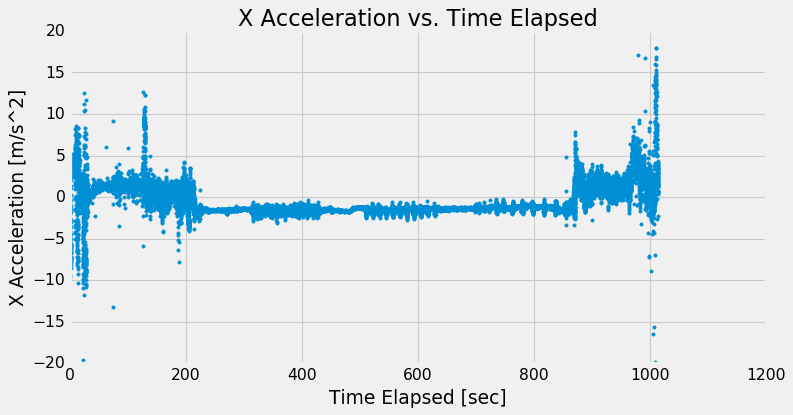

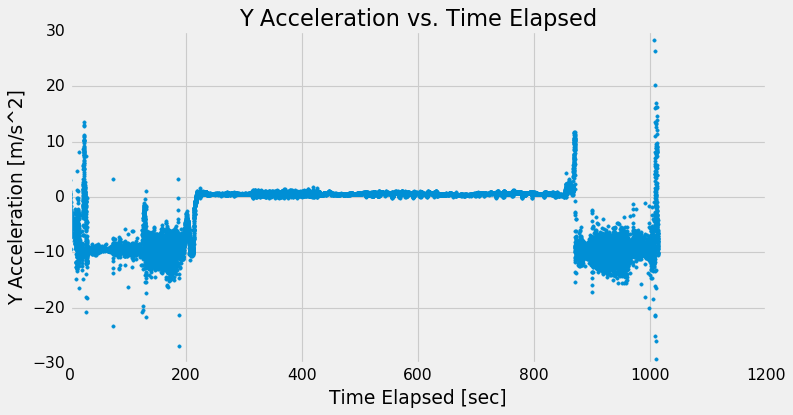

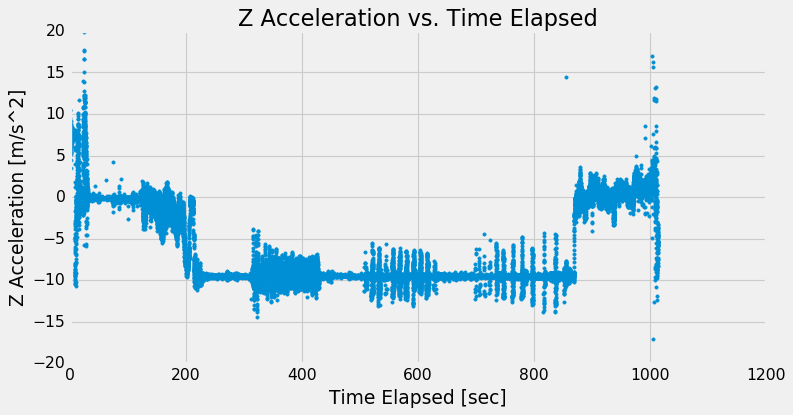

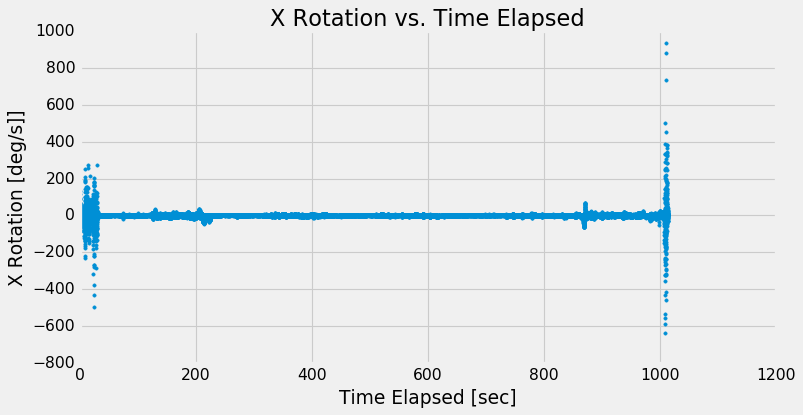

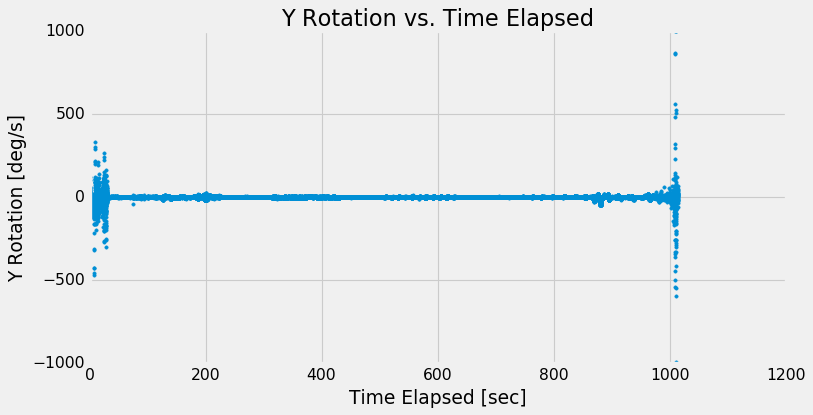

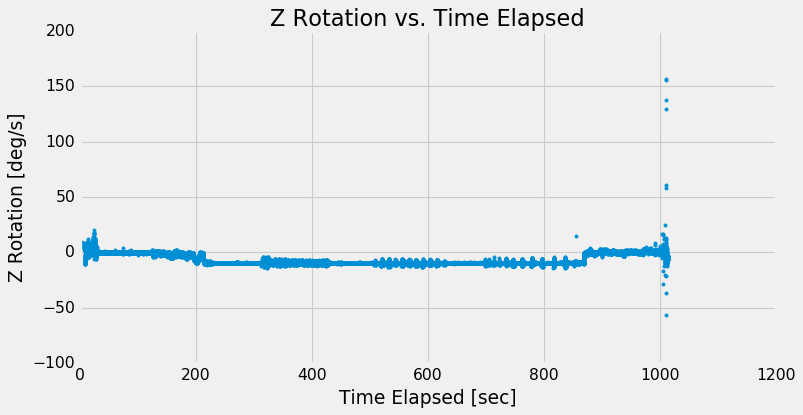

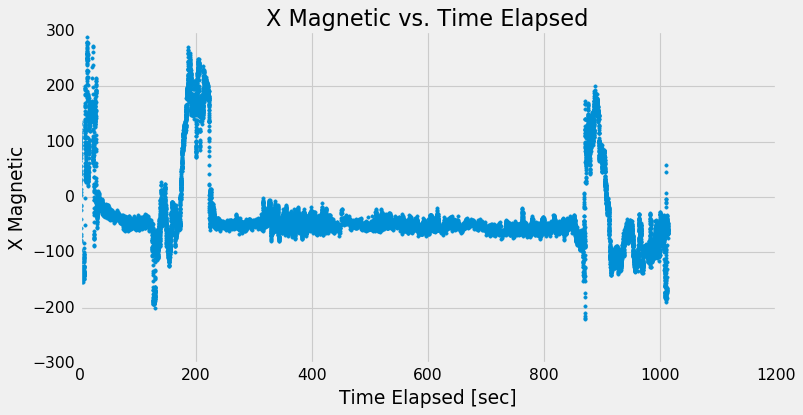

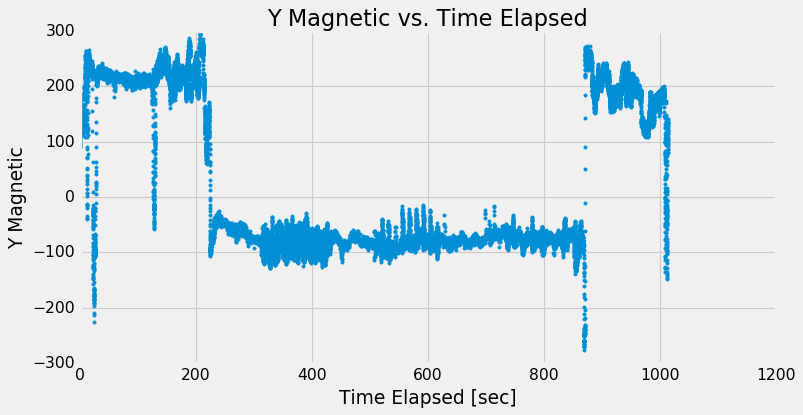

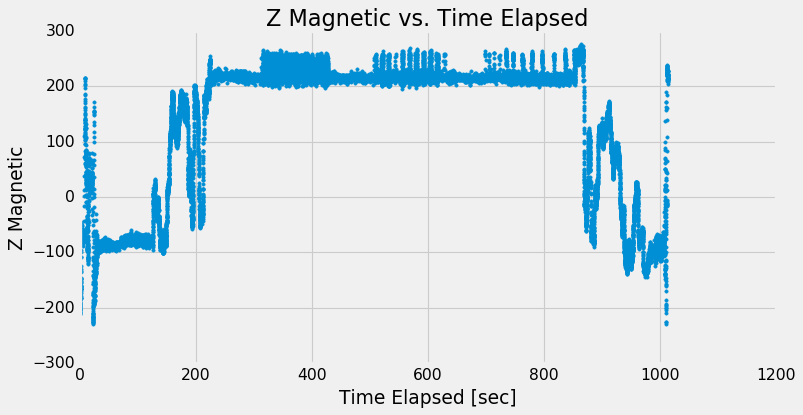

In [79]:
f_ax = plt.figure(figsize=(10,5))
f_ay = plt.figure(figsize=(10,5))
f_az = plt.figure(figsize=(10,5))
f_gx = plt.figure(figsize=(10,5))
f_gy = plt.figure(figsize=(10,5))
f_gz = plt.figure(figsize=(10,5))
f_mx = plt.figure(figsize=(10,5))
f_my = plt.figure(figsize=(10,5))
f_mz = plt.figure(figsize=(10,5))
axi_ax = f_ax.add_subplot(111)     # Plot containing x acceleration
axi_ay = f_ay.add_subplot(111)     # Plot containing y acceleration
axi_az = f_az.add_subplot(111)     # Plot containing z acceleration
axi_gx = f_gx.add_subplot(111)
axi_gy = f_gy.add_subplot(111)
axi_gz = f_gz.add_subplot(111)
axi_mx = f_mx.add_subplot(111)
axi_my = f_my.add_subplot(111)
axi_mz = f_mz.add_subplot(111)

axi_ax.plot(time_e_array, board_acc[:,0], '.')
axi_ax.set_title("X Acceleration vs. Time Elapsed")
axi_ax.set_xlabel("Time Elapsed [sec]")
axi_ax.set_ylabel("X Acceleration [m/s^2]")
axi_ax.set_ylim([-20,20])
axi_ay.plot(time_e_array, board_acc[:,1], '.')
axi_ay.set_title("Y Acceleration vs. Time Elapsed")
axi_ay.set_xlabel("Time Elapsed [sec]")
axi_ay.set_ylabel("Y Acceleration [m/s^2]")
axi_ay.set_ylim([-30,30])
axi_az.plot(time_e_array, board_acc[:,2], '.')
axi_az.set_title("Z Acceleration vs. Time Elapsed")
axi_az.set_xlabel("Time Elapsed [sec]")
axi_az.set_ylabel("Z Acceleration [m/s^2]")
axi_az.set_ylim([-20,20])

axi_gx.plot(time_e_array, board_gyr[:,0], '.')
axi_gx.set_title("X Rotation vs. Time Elapsed")
axi_gx.set_xlabel("Time Elapsed [sec]")
axi_gx.set_ylabel("X Rotation [deg/s]]")
#axi_gx.set_ylim([-360,360])
axi_gy.plot(time_e_array, board_gyr[:,1], '.')
axi_gy.set_title("Y Rotation vs. Time Elapsed")
axi_gy.set_xlabel("Time Elapsed [sec]")
axi_gy.set_ylabel("Y Rotation [deg/s]")
#axi_gy.set_ylim([-360,360])
axi_gz.plot(time_e_array, board_acc[:,2], '.')
axi_gz.set_title("Z Rotation vs. Time Elapsed")
axi_gz.set_xlabel("Time Elapsed [sec]")
axi_gz.set_ylabel("Z Rotation [deg/s]")

axi_mx.plot(time_e_array, board_magn[:,0], '.')
axi_mx.set_title("X Magnetic vs. Time Elapsed")
axi_mx.set_xlabel("Time Elapsed [sec]")
axi_mx.set_ylabel("X Magnetic")
axi_my.plot(time_e_array, board_magn[:,1], '.')
axi_my.set_title("Y Magnetic vs. Time Elapsed")
axi_my.set_xlabel("Time Elapsed [sec]")
axi_my.set_ylabel("Y Magnetic")
axi_mz.plot(time_e_array, board_magn[:,2], '.')
axi_mz.set_title("Z Magnetic vs. Time Elapsed")
axi_mz.set_xlabel("Time Elapsed [sec]")
axi_mz.set_ylabel("Z Magnetic")
plt.show()

## Test Data Zoom Graph

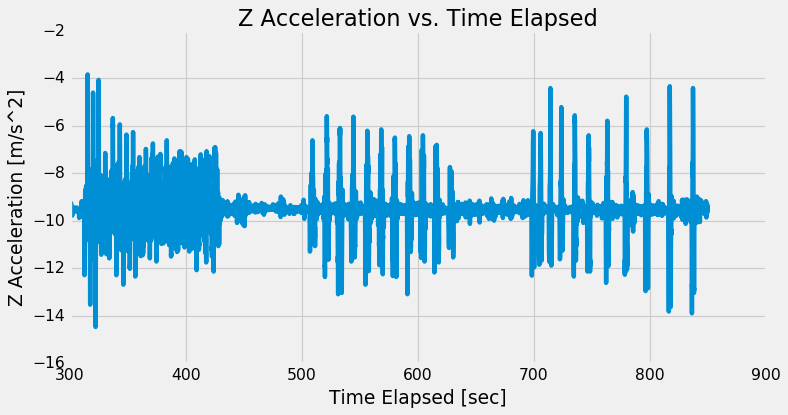

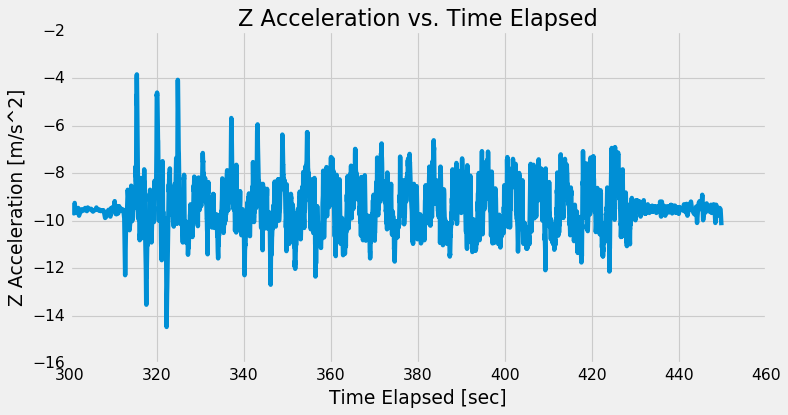

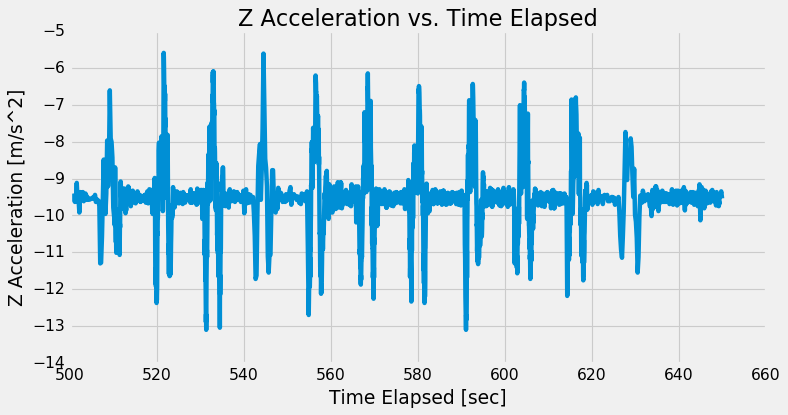

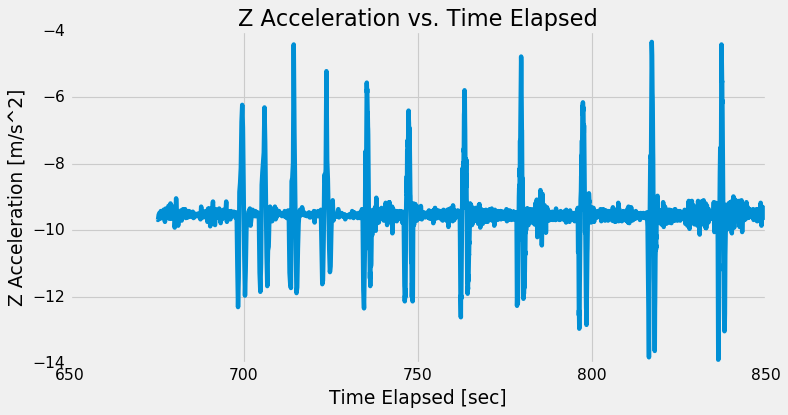

In [80]:
is_test_data = 1
lower_time = 300
upper_time = 850
zoom_title = "Z Acceleration vs. Time Elapsed"
Y_axi_zoom_label = "Z Acceleration [m/s^2]"
X_axi_zoom_label = "Time Elapsed [sec]"
def zoom_data_array(data_array, time_elapsed, lower_time, upper_time, zoom_title, y_label, x_label):
    ret_time_array = []
    ret_data_array = []
    iterator = 0
    while iterator < len(time_elapsed):
        if time_elapsed[iterator] > lower_time and time_elapsed[iterator] < upper_time:
            ret_time_array.append(time_elapsed[iterator])
            ret_data_array.append(data_array[iterator])
        iterator += 1
    f_data_zoom = plt.figure(figsize=(10,5))
    axi_data_zoom = f_data_zoom.add_subplot(111)
    axi_data_zoom.plot(ret_time_array, ret_data_array)
    axi_data_zoom.set_title(zoom_title)
    axi_data_zoom.set_xlabel(x_label)
    axi_data_zoom.set_ylabel(y_label)
    plt.show()

if is_test_data == 1:
    lower_time1 = 300
    lower_time2 = 500
    lower_time3 = 675
    upper_time1 = 450
    upper_time2 = 650
    upper_time3 = 850
    zoom_data_array(board_acc[:,2], time_e_array, lower_time, upper_time, zoom_title, Y_axi_zoom_label, X_axi_zoom_label)
    zoom_data_array(board_acc[:,2], time_e_array, lower_time1, upper_time1, zoom_title, Y_axi_zoom_label, X_axi_zoom_label)
    zoom_data_array(board_acc[:,2], time_e_array, lower_time2, upper_time2, zoom_title, Y_axi_zoom_label, X_axi_zoom_label)
    zoom_data_array(board_acc[:,2], time_e_array, lower_time3, upper_time3, zoom_title, Y_axi_zoom_label, X_axi_zoom_label)

## Calculating Heading via Azimuth and Altitude

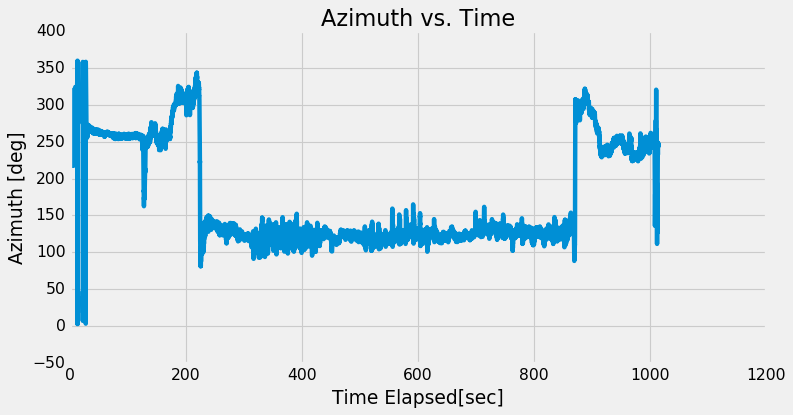

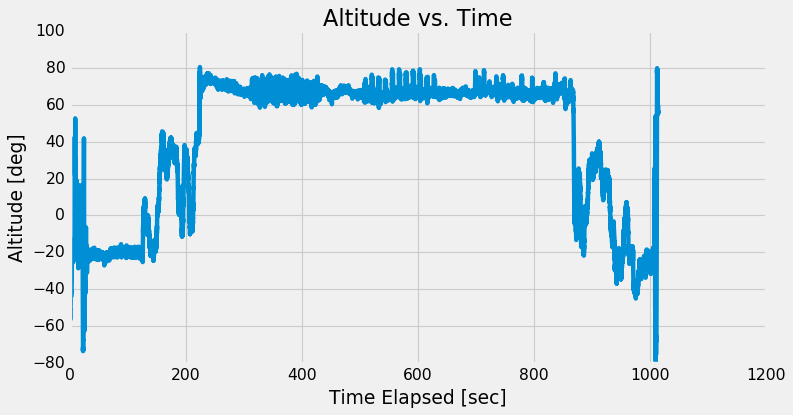

In [81]:
# This will get complicated (ie make cases or lots of if statements) when rotations about the heading become more prevalent
def azimuth(x,y,z):
    real_y = y * (-1) # This is to account for y 
    return (180/math.pi * math.atan2(real_y,x)) % 360

def altitude(x,y,z):
    h = math.hypot(y, x)
    return 180/math.pi * math.atan2(z,h)

def printAltAzi(alt, azi):
    print ("Alt:", alt, "\n", "Azi:",azi,"\n")
# These values are uncorrected values: still need to add or subtract 'declination'
#     (for AziMuth) and 'inclination' (for Altitude) correction values for geographical location
# Altitude is the angle between the ground and the vector 
# Azimuth is the angle going clockwise from 0 deg North

heading_altitude = board_magn[:,0].copy()
heading_azimuth = board_magn[:,0].copy()

i = 0     #iterator
#for i in range(len(M1_no_out)):
while i < len(heading_altitude):
    heading_altitude[i] = altitude(board_magn[i,0], board_magn[i,1], board_magn[i,2])
    heading_azimuth[i] = azimuth(board_magn[i,0], board_magn[i,1], board_magn[i,2])
    #printAltAzi(heading_altitude[i],heading_azimuth[i])
    i += 1

heading_azi_plot = plt.figure(figsize=(10,5))
azi_plot = heading_azi_plot.add_subplot(111)
azi_plot.plot(time_e_array, heading_azimuth)
azi_plot.set_title("Azimuth vs. Time")
azi_plot.set_xlabel("Time Elapsed[sec]")
azi_plot.set_ylabel("Azimuth [deg]")
azi_plot.set_ylim([-50,400])

heading_alt_plot = plt.figure(figsize=(10,5))
alt_plot = heading_alt_plot.add_subplot(111)
alt_plot.plot(time_e_array, heading_altitude)
alt_plot.set_title("Altitude vs. Time")
alt_plot.set_xlabel("Time Elapsed [sec]")
alt_plot.set_ylabel("Altitude [deg]")
plt.show()

#for t in range(len(time_e_array)):
    #printAltAzi(heading_altitude[t], heading_azimuth[t])
    

### 3D plot to Help Visualize Azimuth Alitude

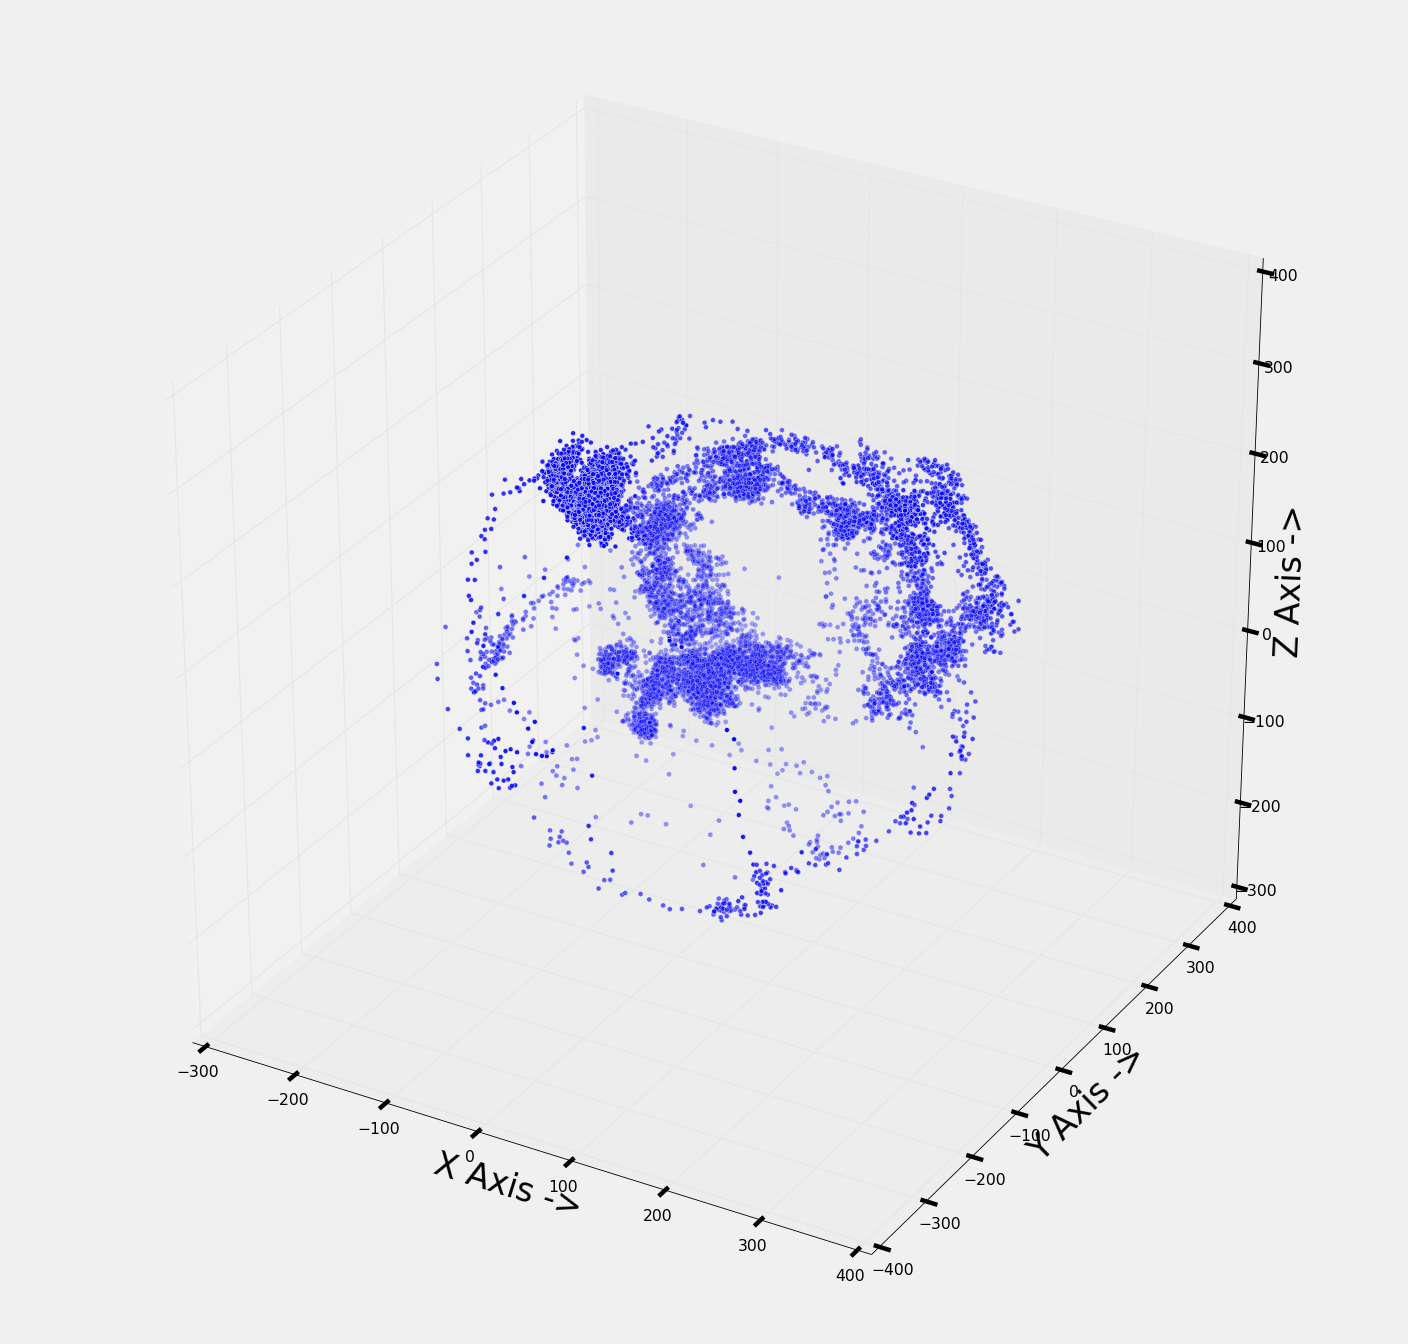

In [82]:
magnfig = plt.figure(figsize=(20,20))
magnaxi = magnfig.add_subplot(111, projection='3d')
magnaxi.scatter(board_magn[:,0], board_magn[:,1], board_magn[:,2])
magnaxi.set_xlabel("X Axis ->", fontsize=30)
magnaxi.set_ylabel("Y Axis ->", fontsize=30)
magnaxi.set_zlabel("Z Axis ->", fontsize=30)
plt.show()

## Setting Up Magnetic North to Magnetic North Rotation (Roll Not Accounted For)

In [83]:
# Enter the EXACT number that is shown for declination (since yaw and azimuth opposite directions/signs)
# Enter the EXACT number that is shown for inclination
declination = 11.5
inclination = 57.87
LFF_fick_yaw = (-1)*declination
LFF_fick_pitch = inclination
LFF_fick_roll = 0

# Convert angles entered to radians for trig functions
Y = np.deg2rad(LFF_fick_yaw)
P = np.deg2rad(LFF_fick_pitch)
R = np.deg2rad(LFF_fick_roll)
# Set up the Fick angle matrix
c11 = np.cos(Y)*np.cos(P)
c12 = np.cos(Y)*np.sin(P)*np.sin(R) - np.sin(Y)*np.sin(R)
c13 = np.cos(Y)*np.sin(P)*np.cos(R) + np.sin(Y)*np.sin(R)
c21 = np.sin(Y)*np.cos(P)
c22 = np.sin(Y)*np.sin(P)*np.sin(R) + np.cos(Y)*np.cos(R)
c23 = np.sin(Y)*np.sin(P)*np.cos(R) - np.cos(Y)*np.sin(R)
c31 = (-1)*np.sin(P)
c32 = np.cos(P)*np.sin(R)
c33 = np.cos(P)*np.cos(R)

rotmat_lff2mag = np.array([[c11, c12, c13],
                        [c21, c22, c23],
                        [c31, c32, c33]])

print("rotmat_lff2mag: \n", rotmat_lff2mag, "\n")
lff2mag_rad = rotmat.sequence(rotmat_lff2mag, 'Fick') # Check if the matrix accurately represents the desired Fick angles
lff2mag_deg = lff2mag_rad * 180/np.pi
print("lff2mag_deg Fick Angles: \n", lff2mag_deg,"\n")

# Now find the inverse of the matrix, since we want to go from magnetic field to LFF
#rotmat_mag2lff = np.matrix.transpose(rotmat_lff2mag)
rotmat_mag2lff = np.linalg.inv(rotmat_lff2mag)
print("rotmat_mag2lff: \n", rotmat_mag2lff, "\n")
mag2lff_rad = rotmat.sequence(rotmat_mag2lff, 'Fick')
mag2lff_deg = mag2lff_rad * 180/np.pi
print("mag2lff_deg Fick Angles: \n", mag2lff_deg, "\n")

print("Is it identity matrix?: \n", np.matmul(rotmat_lff2mag,rotmat_mag2lff))
mag2lff_helm_rad = rotmat.sequence(rotmat_mag2lff, 'Helmholtz')
mag2lff_helm_deg = mag2lff_helm_rad * 180/np.pi
print("mag2lff_deg Helmholtz Angles: \n", mag2lff_helm_deg, "\n")

Q_mag2lff = rotmat.seq2quat(mag2lff_deg, 'Fick')
print("Transformation Quaternion for mag2lff: \n", Q_mag2lff) #Print out quaternion describing the transformation

rotmat_lff2mag: 
 [[ 0.52116517  0.          0.82984293]
 [-0.10603225  0.9799247  -0.16883345]
 [-0.84684357  0.          0.53184206]] 

lff2mag_deg Fick Angles: 
 [-11.5   57.87   0.  ] 

rotmat_mag2lff: 
 [[  5.42737678e-01  -0.00000000e+00  -8.46843566e-01]
 [  2.07620339e-01   1.02048657e+00   3.65362550e-17]
 [  8.64192485e-01   0.00000000e+00   5.31842059e-01]] 

mag2lff_deg Fick Angles: 
 [ 20.933987   -59.79062512   0.        ] 

Is it identity matrix?: 
 [[  1.00000000e+00   0.00000000e+00   7.09307209e-17]
 [ -1.13267885e-17   1.00000000e+00   1.91919225e-17]
 [  1.27816841e-17   0.00000000e+00   1.00000000e+00]]
mag2lff_deg Helmholtz Angles: 
 [  1.19829344e+01  -6.20605416e+01  -2.14000502e-15] 

Transformation Quaternion for mag2lff: 
 [[ 0.85251145  0.09054692 -0.49012302  0.15749573]]


## Setting Up Initial Position (Azimuth / Altitude) Rotation Matrix (No Roll)

In [84]:
# Yaw rotation - convert azimuth to yaw, since they are opposites of each other in direction
print("Initial Azimuth and Altitude: \n", heading_azimuth[0], heading_altitude[0], "\n")
init_yaw = heading_azimuth[0] * (-1)
init_pos_first_rotation = rotmat.R('z', init_yaw)                               #print(init_pos_first_rotation, "\n")

rotmat_first_init_rot_rad = rotmat.sequence(init_pos_first_rotation, to='Fick')
rotmat_first_init_rot_deg = rotmat_first_init_rot_rad * 180/np.pi               #print(rotmat_first_init_rot_deg)

# Pitch rotation - convert alitude to pitch, since they are opposites of each other in direction
init_pitch = heading_altitude[0] * (-1)
init_pos_second_rotation = rotmat.R('y', init_pitch)                            #print(init_pos_second_rotation, "\n")

rotmat_second_init_rot_rad = rotmat.sequence(init_pos_second_rotation, to='Fick')
rotmat_second_init_rot_deg = rotmat_second_init_rot_rad * 180/np.pi             #print(rotmat_second_init_rot_deg)

rotmat_init_pos = np.matmul(init_pos_first_rotation, init_pos_second_rotation)  #print(rotmat_init_pos, "\n")

# Combine rotations into a single sequence of rotations
Initial_Position_offset_rad = rotmat.sequence(rotmat_init_pos, to='Fick')
Initial_Position_offset_deg = Initial_Position_offset_rad * 180/np.pi
Q_init_pos = rotmat.seq2quat(Initial_Position_offset_deg, 'Fick')
print("Initial Orientation Rotation Matrix: \n", rotmat_init_pos, "\n")
print("Initial Orientation Fick Angles: \n", Initial_Position_offset_deg, "\n")
print("Initial Orientation Quaternion: \n", Q_init_pos)

Initial Azimuth and Altitude: 
 271.391693758 -34.414147822 

Initial Orientation Rotation Matrix: 
 [[ 0.02003635 -0.99970502  0.01372644]
 [ 0.82473062  0.02428725  0.56500401]
 [-0.56517073  0.          0.82497397]] 

Initial Orientation Fick Angles: 
 [ 88.60830624  34.41414782   0.        ] 

Initial Orientation Quaternion: 
 [[ 0.68361129 -0.20662474  0.21170553  0.66720506]]


## Creating Delta Quaternions from imus.kalman function
They're delta quaternions since they have no initial position and each rotation is slightly different from the next one.
We should be able to apply rotation quaternions to these delta quaternions to transform them into their proper, real world position.

In [85]:
# Calculate the delta quaternions relative to the Earth's magnetic reference frame from the rate, accelerometer, gyro,
#     and magnetic data. All functions automatically iterate through arrays unless specified otherwise
rate = 33 # Frequency of data polling in Hz
board_gyr_rad = board_gyr * np.pi/180     # Converting from degrees to radians for the kalman function to create quaternions
delta_quats = imus.kalman(rate,board_acc,board_gyr_rad,board_magn)
#print(len(delta_quats))
#print(delta_quats)
print("Kalman quaternions finished.")

init_rotated_quats = quat.q_mult(Q_init_pos, delta_quats) # Using delta_quats instead of vector quats to avoid unit length
#print(init_rotated_quats, "\n")

#init_rotated_quats2 = quat.q_mult(delta_vectors, Q_init_pos)
#print(init_rotated_quats2)
print("Initial orientation quaternion applied to Kalman quats.")

final_orient_quats = quat.q_mult(Q_mag2lff, init_rotated_quats)
#print(final_orient_quats) # Still delta quaternions, not absolute position/angles
print("Magnetic to LFF quaternion applied to other quats.")

Kalman quaternions finished.
Initial orientation quaternion applied to Kalman quats.
Magnetic to LFF quaternion applied to other quats.


### Orientation Viewer Check

In [86]:
# Enter 2 to view geographic animation, 1 to view raw animation, otherwise set to 0 for none
view_animation = 0
print(len(delta_quats))
print(np.floor(1000/60))
print("Done.")

23432
16.0
Done.


### Orientation Viewer

In [87]:
pygame.init()
if view_animation == 1:
    #view.orientation(quat_array, out_file=None, title_text='Ride 13735 Filtered', deltaT = 1000)
    viewer = view.Orientation_OGL(delta_quats, rate = 30) #Make the simulation run at 250ms intervals, so show "real time" movement
    viewer.run(looping=False, rate=120)                     #Force the simulation to run at 4Hz to match the 250ms intervals
    # Close the window to prevent kernel crash at the end
    pygame.display.quit()
    #view.ts(quat_array)
elif view_animation == 2:
    viewer = view.Orientation_OGL(final_orient_quats, rate == 30)
    viewer.run(looping=False, rate = 120) # Run it at 4 times speed to speed things up
    pygame.display.quit()
print("All Done.")

All Done.


## Converting Final Quaternions Back to Euler Angle (Fick orientation: Yaw->Pitch->Roll)
This function was pulled from the Wikipedia page for Quaternion to Euler conversion. It's the only solution that has worked so far. The Scikit Kinematics functions have an issue with angles, and they "reflect" at the 90/-90 degree mark, preventing full yaw rotation.

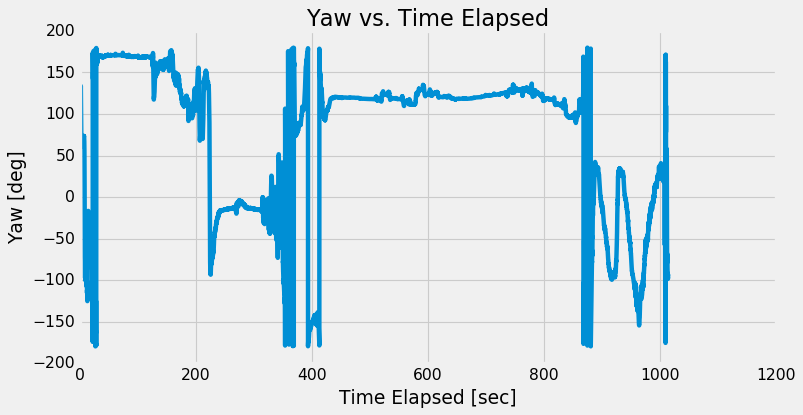

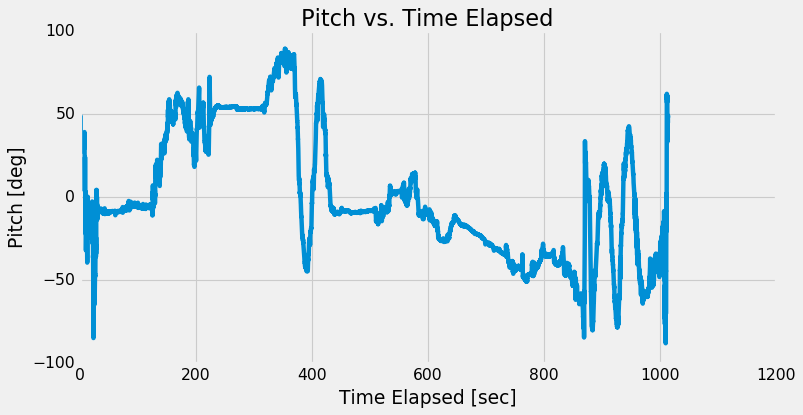

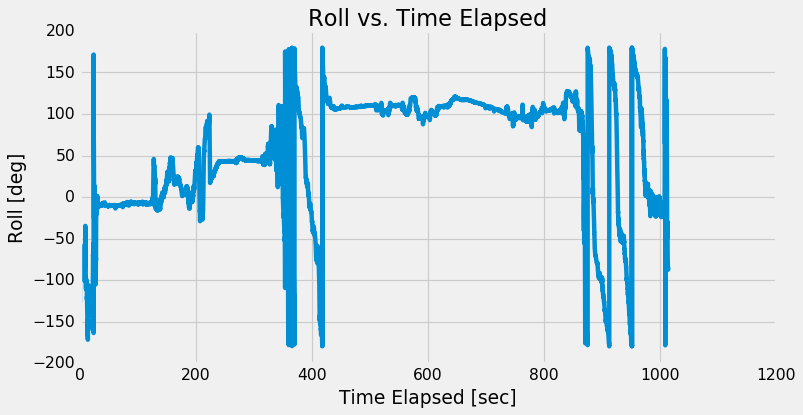

In [88]:
# This was pulled from the wikipedia page for Quaternion to Euler Conversion. It's the only solution that works.
def quaternion_to_euler_angle(w, x, y, z):
    
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.degrees(math.atan2(t0, t1))
    
    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.degrees(math.asin(t2))
    
    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.degrees(math.atan2(t3, t4))
    
    return X, Y, Z

wiki_soln = np.zeros(shape=(len(final_orient_quats),3))
for i in range(len(final_orient_quats)):
    w = final_orient_quats[i,0]
    x = final_orient_quats[i,1]
    y = final_orient_quats[i,2]
    z = final_orient_quats[i,3]
    roll, pitch, yaw = quaternion_to_euler_angle(w, x, y, z)
    wiki_soln[i,0] = yaw
    wiki_soln[i,1] = pitch
    wiki_soln[i,2] = roll

#for j in range(len(wiki_soln)):
#    print(wiki_soln[j,:])
fig_yaw_wiki = plt.figure(figsize=(10,5))
fig_pitch_wiki = plt.figure(figsize=(10,5))
fig_roll_wiki = plt.figure(figsize=(10,5))
axiw_yaw = fig_yaw_wiki.add_subplot(111)
axiw_pitch = fig_pitch_wiki.add_subplot(111)
axiw_roll = fig_roll_wiki.add_subplot(111)
axiw_yaw.plot(time_e_array, wiki_soln[:,0])
axiw_yaw.set_title("Yaw vs. Time Elapsed")
axiw_yaw.set_xlabel("Time Elapsed [sec]")
axiw_yaw.set_ylabel("Yaw [deg]")
axiw_pitch.plot(time_e_array, wiki_soln[:,1])
axiw_pitch.set_title("Pitch vs. Time Elapsed")
axiw_pitch.set_xlabel("Time Elapsed [sec]")
axiw_pitch.set_ylabel("Pitch [deg]")
axiw_roll.plot(time_e_array, wiki_soln[:,2])
axiw_roll.set_title("Roll vs. Time Elapsed")
axiw_roll.set_xlabel("Time Elapsed [sec]")
axiw_roll.set_ylabel("Roll [deg]")
plt.show()  

## Calculating Vertical Component of Acceleration (In Earth Frame)

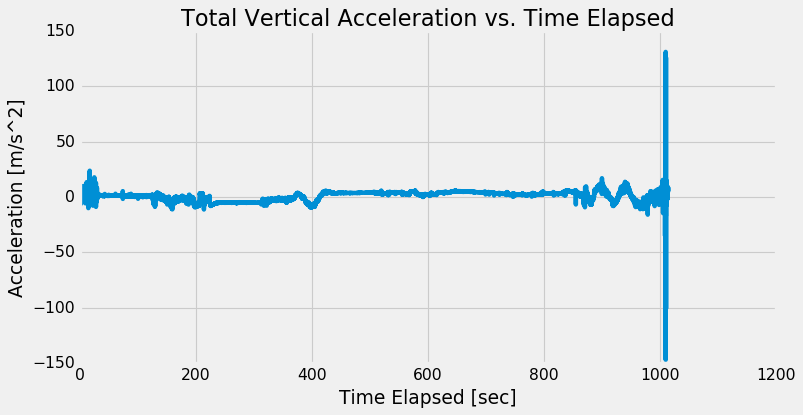

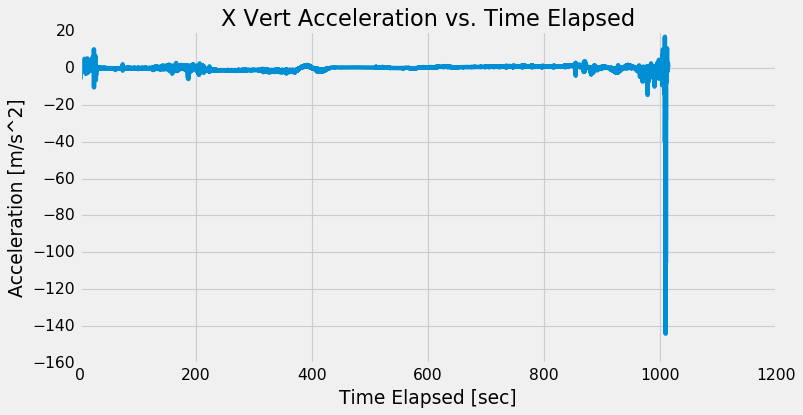

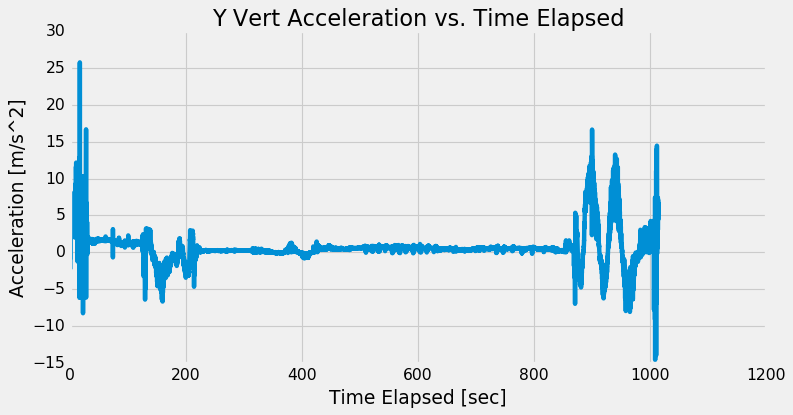

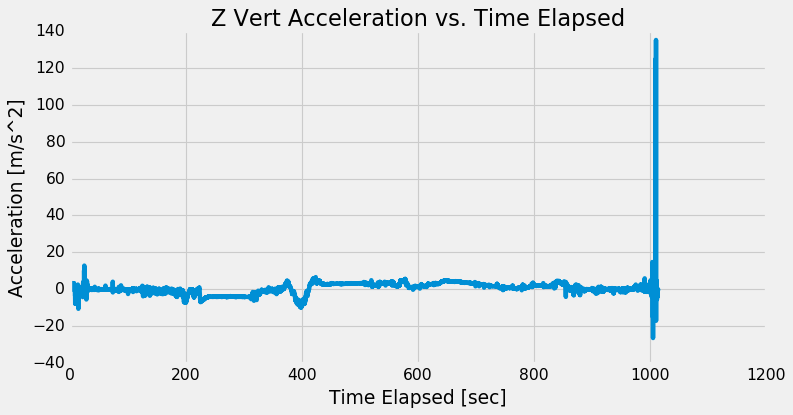

In [89]:
lff_yaw = wiki_soln[:,0]
lff_pitch = wiki_soln[:,1]
lff_roll = wiki_soln[:,2]
# Create the properly sized arrays for each vertical component
x_vert = lff_yaw.copy()
y_vert = lff_pitch.copy()
z_vert = lff_roll.copy()
total_vert = lff_yaw.copy()

for i in range(len(wiki_soln)):
    curr_yaw = np.deg2rad(lff_yaw[i])
    curr_pitch = np.deg2rad(lff_pitch[i])
    curr_roll = np.deg2rad(lff_roll[i])
    x_vert[i] = np.sin(curr_pitch) * board_acc[i,0]
    y_vert[i] = np.cos(curr_pitch) * np.sin(curr_roll) * board_acc[i,1]
    z_vert[i] = np.cos(curr_pitch) * np.cos(curr_roll) * board_acc[i,2]
    total_vert[i] = x_vert[i] + y_vert[i] + z_vert[i]
    #print(total_vert[i])
    
fig_total_vert = plt.figure(figsize=(10,5))
fig_x_vert = plt.figure(figsize=(10,5))
fig_y_vert = plt.figure(figsize=(10,5))
fig_z_vert = plt.figure(figsize=(10,5))
axi_tot_vert = fig_total_vert.add_subplot(111)
axi_x_vert = fig_x_vert.add_subplot(111)
axi_y_vert = fig_y_vert.add_subplot(111)
axi_z_vert = fig_z_vert.add_subplot(111)
axi_tot_vert.plot(time_e_array, total_vert)
axi_tot_vert.set_title("Total Vertical Acceleration vs. Time Elapsed")
axi_tot_vert.set_xlabel("Time Elapsed [sec]")
axi_tot_vert.set_ylabel("Acceleration [m/s^2]")
axi_x_vert.plot(time_e_array, x_vert)
axi_x_vert.set_title("X Vert Acceleration vs. Time Elapsed")
axi_x_vert.set_xlabel("Time Elapsed [sec]")
axi_x_vert.set_ylabel("Acceleration [m/s^2]")
axi_y_vert.plot(time_e_array, y_vert)
axi_y_vert.set_title("Y Vert Acceleration vs. Time Elapsed")
axi_y_vert.set_xlabel("Time Elapsed [sec]")
axi_y_vert.set_ylabel("Acceleration [m/s^2]")
axi_z_vert.plot(time_e_array, z_vert)
axi_z_vert.set_title("Z Vert Acceleration vs. Time Elapsed")
axi_z_vert.set_xlabel("Time Elapsed [sec]")
axi_z_vert.set_ylabel("Acceleration [m/s^2]")
plt.show()  
    

## Plot Acceleration on A2 for comparison against Z vert

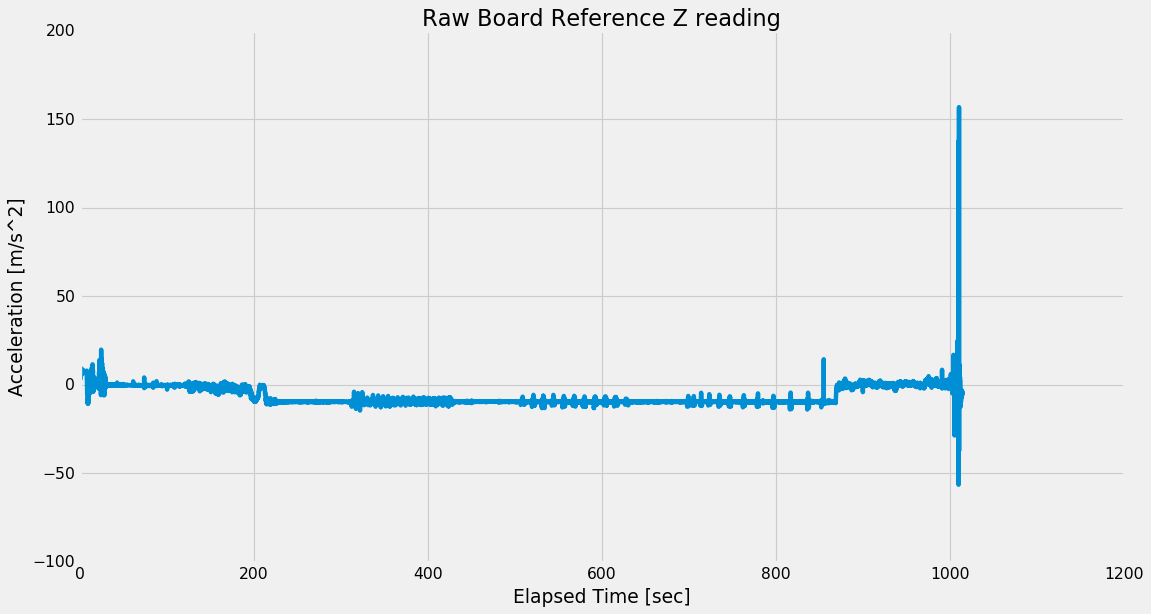

In [90]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111)
ax1.plot(time_e_array, board_acc[:,2])
ax1.set_title('Raw Board Reference Z reading')
ax1.set_xlabel('Elapsed Time [sec]')
ax1.set_ylabel('Acceleration [m/s^2]')

plt.show()

[ -9.32780967 -10.22802949 -10.13226143 ...,  -3.33272871  -4.55855996
  -4.59686719]
13680


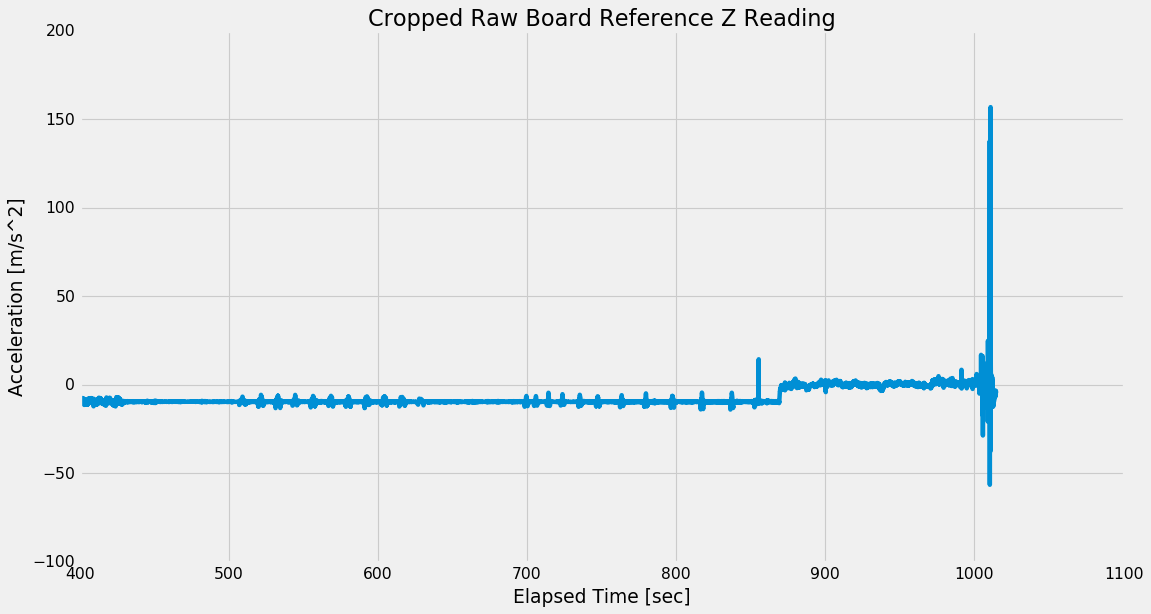

In [91]:
# Create new data set for when z reading is roughly 9.8 (not on its side)
time_cropped = []
z_acc_cropped = []

for i in range(len(time_e_array)):
    if time_e_array[i] > 400 and time_e_array[i] < 3400:
        time_cropped = np.append(time_cropped, time_e_array[i])
        z_acc_cropped = np.append(z_acc_cropped, board_acc[i,2])

print(z_acc_cropped)
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111)
ax1.plot(time_cropped, z_acc_cropped)
ax1.set_title('Cropped Raw Board Reference Z Reading')
ax1.set_xlabel('Elapsed Time [sec]')
ax1.set_ylabel('Acceleration [m/s^2]')
print(len(time_cropped))

plt.show()

## Convert to Frequency Domain to filter out unwanted frequencies

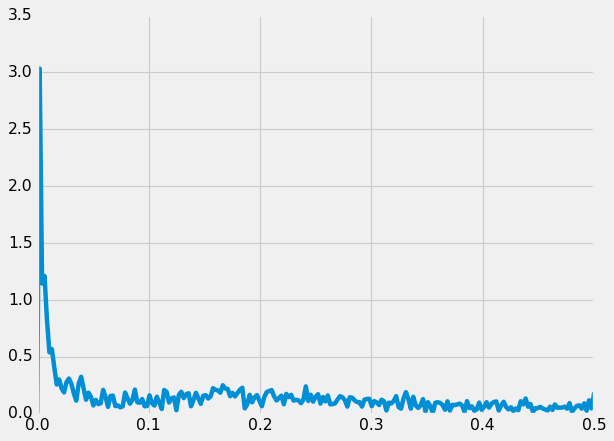

In [92]:
z_acc_crop_trend = signal.detrend(z_acc_cropped)     #Detrend the data to eliminate any drift prior to freq domain
#z_acc_crop_trend = z_acc_cropped.copy()
z_fft_c = np.fft.fft(z_acc_crop_trend)          #Take the FFT of the cropped, detrended Z acceleration
n = len(z_fft_c)
f_s = 30 #Hz
freq = np.fft.fftfreq(n, 1/f_s)

z_fft_c_shift = np.fft.fftshift(z_fft_c)     #Shift the FFT points over to center the 0 frequency
freq_shift = np.fft.fftshift(freq)           #Shift the frequencies over to center them at 0 frequency

z_fft_normal = np.abs(z_fft_c_shift / n)
z_fft_normal_1side = z_fft_normal * 2
#z_fft_normal_sq = np.power(z_fft_normal_1side, 2)


plt.plot(freq_shift, z_fft_normal_1side)
plt.xlim(0.0,0.5)
plt.show()

### Pass the Frequency Data through a Butterworth Bandpass filter

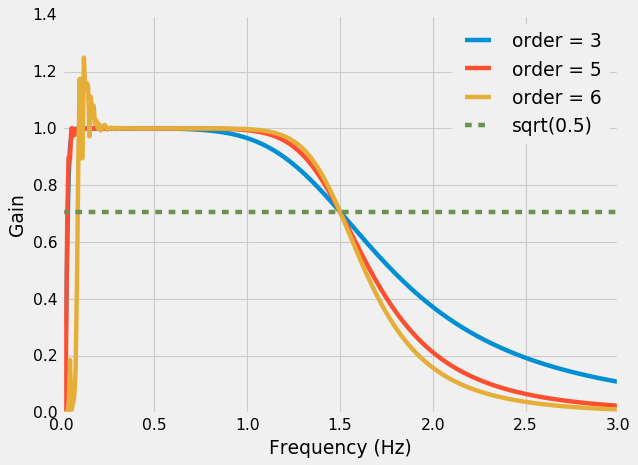

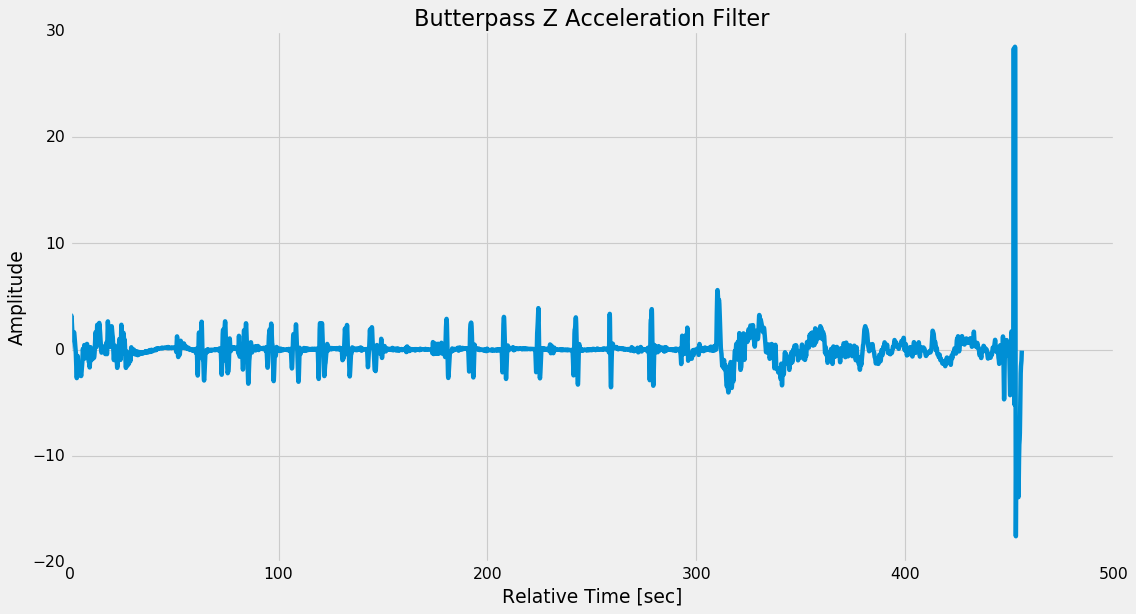

In [93]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Define the sample rate and the Low and High Cutoff frequencies
fs = 30
lowcut = 0.0333
highcut = 1.5

# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [3, 5, 6]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = signal.freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.xlim(0.0,3)
plt.grid(True)
plt.legend(loc='best')

#T = 0.05
#nsamples = T * fs
#t = np.linspace(0, T, nsamples, endpoint=False)
#a = 0.02
#f0 = 600.0
#x = 0.1 * np.sin(2 * np.pi * 1.2 * np.sqrt(t))
#x += 0.01 * np.cos(2 * np.pi * 312 * t + 0.1)
#x += a * np.cos(2 * np.pi * f0 * t + .11)
#x += 0.03 * np.cos(2 * np.pi * 2000 * t)
#plt.figure(2)
#plt.clf()
#plt.plot(t, x, label='Noisy signal')

butterbp_z = butter_bandpass_filter(z_acc_crop_trend, lowcut, highcut, fs, order=5)
new_time = time_cropped.copy()
for i in range(len(new_time)):
    if i == 0:
        new_time[i] = 0
    else:
        new_time[i] = new_time[i-1] + 1/fs

#plt.plot(t, y, label='Filtered signal (%g Hz)' % f0)
#plt.xlabel('time (seconds)')
#plt.hlines([-a, a], 0, T, linestyles='--')
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111)
ax1.plot(new_time, butterbp_z)
ax1.set_title('Butterpass Z Acceleration Filter')
ax1.set_xlabel('Relative Time [sec]')
ax1.set_ylabel('Amplitude')

#plt.plot(freq_shift,butterbp_z_fft)
#plt.legend(loc='upper left')

plt.show()

### Take filtered data and take FFT

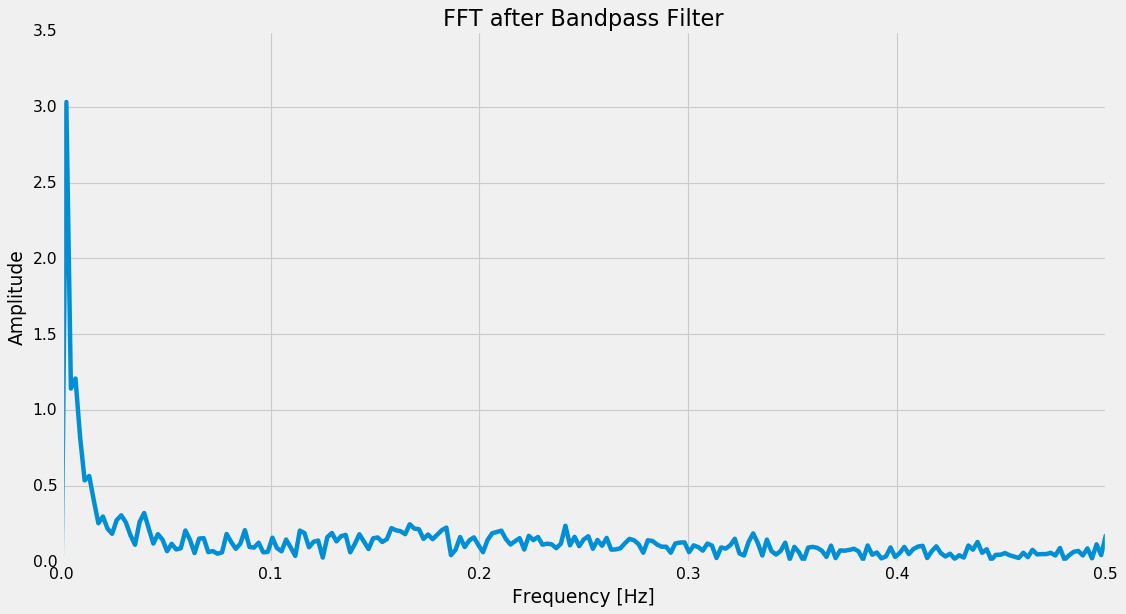

In [94]:
fft_z = np.fft.fft(butterbp_z)
n = len(fft_z)
f_s = 30 #Hz
freq_z = np.fft.fftfreq(n, 1/f_s)

fft_z_shift = np.fft.fftshift(fft_z)     #Shift the FFT points over to center the 0 frequency
freq_z_shift = np.fft.fftshift(freq_z)           #Shift the frequencies over to center them at 0 frequency

fft_z_normal = np.abs(fft_z_shift / n)
fft_z_normal_1side = z_fft_normal * 2
#z_fft_normal_sq = np.power(z_fft_normal_1side, 2)

fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111)
ax1.plot(freq_z_shift, fft_z_normal_1side)
ax1.set_title('FFT after Bandpass Filter')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Amplitude')
ax1.set_xlim(0.0,0.5)

plt.show()

### Use scipy.cumtrapzto calculate the integrals for velocity and displacement for butterbp_z

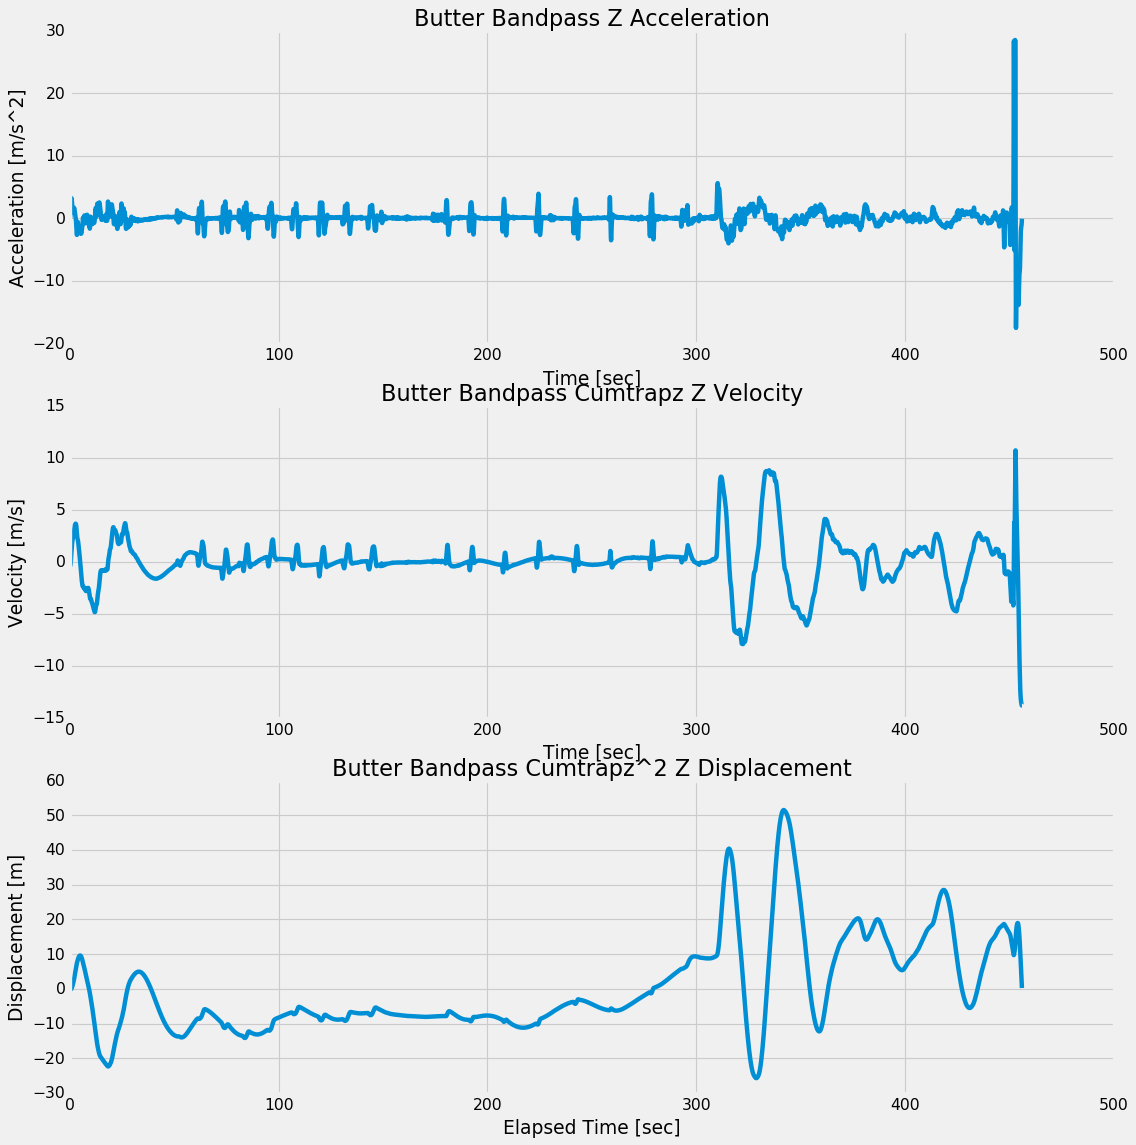

In [95]:
butterbp_z_vel = scipy.integrate.cumtrapz(butterbp_z, new_time)     # Integrate the acceleration signal to get base velocity
#print(len(butterbp_z_vel), len(new_time))                          # Check the lengths of the arrays for matching lengths
butterbp_z_vel = np.append(butterbp_z_vel, butterbp_z_vel[len(butterbp_z_vel)-1])     # Repeat last value on velocity to force same length
butterbp_z_vel_trend = signal.detrend(butterbp_z_vel)     # Detrend the signal to remove any constant offsets or trends


butterbp_z_pos = scipy.integrate.cumtrapz(butterbp_z_vel_trend, new_time)     # Integrate velocity to get base position
#print(len(butterbp_z_pos), len(new_time))     # Check the lengths of the arrays for matching lengths
butterbp_z_pos = np.append(butterbp_z_pos, butterbp_z_pos[len(butterbp_z_pos)-1])     # Repeat last value on position to force same length
butterbp_z_pos_trend = signal.detrend(butterbp_z_pos)     # Detrend the signal to remove any constant offsets or trends

# Plot the signals for acceleration, velocity, and position
fig = plt.figure(figsize=(15,16))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.plot(new_time, butterbp_z)
ax1.set_title('Butter Bandpass Z Acceleration')
ax1.set_xlabel('Time [sec]')
ax1.set_ylabel('Acceleration [m/s^2]')

ax2.plot(new_time, butterbp_z_vel_trend)
ax2.set_title('Butter Bandpass Cumtrapz Z Velocity')
ax2.set_xlabel('Time [sec]')
ax2.set_ylabel('Velocity [m/s]')

ax3.plot(new_time, butterbp_z_pos)
ax3.set_title('Butter Bandpass Cumtrapz^2 Z Displacement')
ax3.set_xlabel('Elapsed Time [sec]')
ax3.set_ylabel('Displacement [m]')

plt.show()

(13680,)      (13680,)


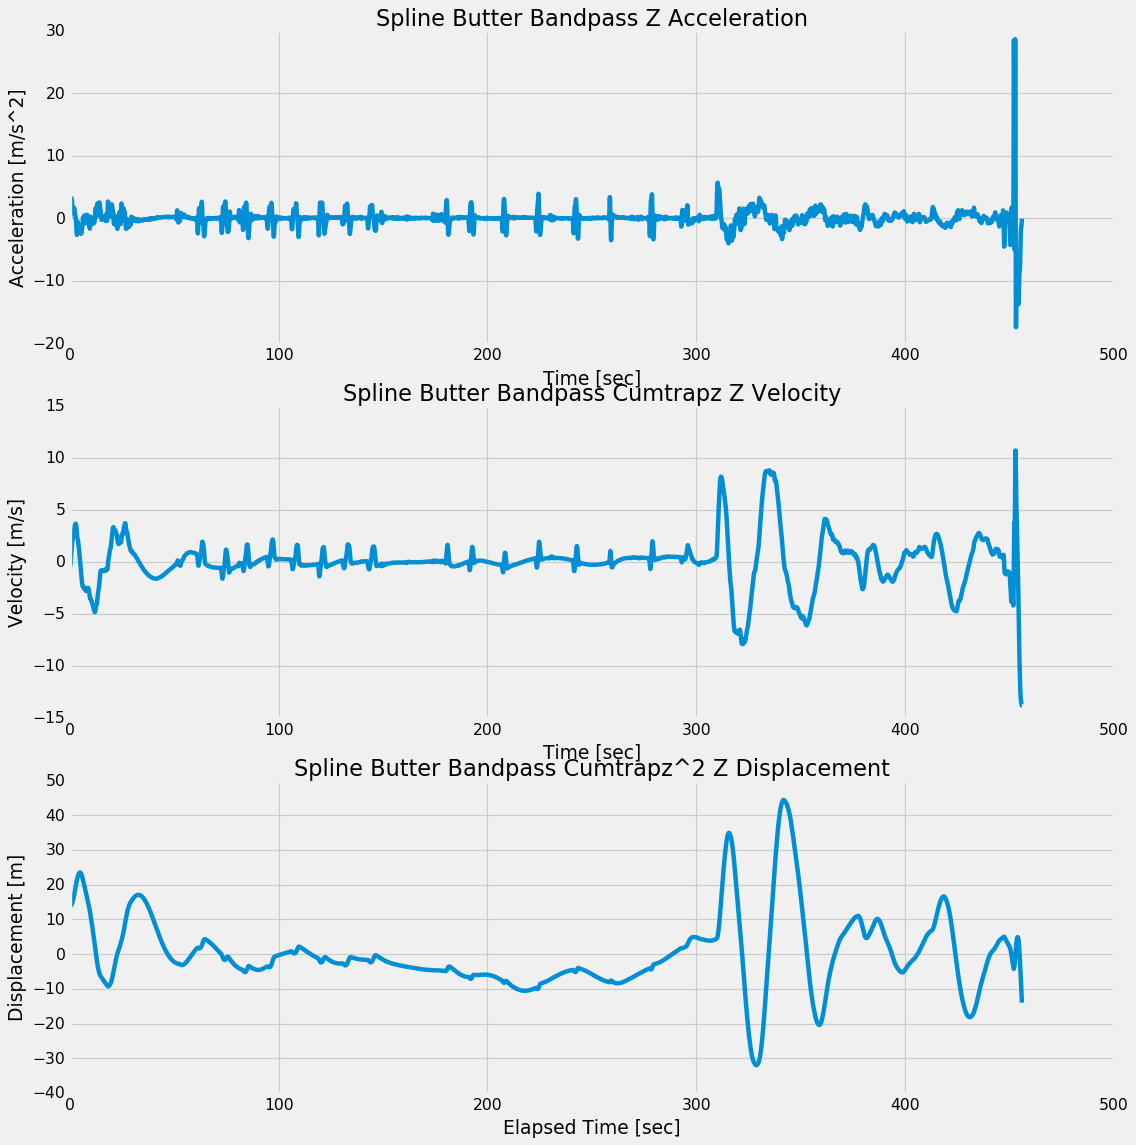

In [96]:
# This function adds points back into an array form (since CubicSpline output alone is awkward to handle)
def add_interpolated_pts(a_array, time_array, std, cs):
    i = 0
    ret_acc = []
    while i < (len(a_array)):
        if abs(a_array[i]) > std:
            ret_acc.append(cs(time_array[i]))
        else:
            ret_acc.append(a_array[i])
        i = i + 1  
    return ret_acc;


def calculate_new_range(time_array, array_of_values, low_time, high_time):
    new_time_array = []
    new_value_array = []
    for t,v in zip(time_array, array_of_values):
        if (t > low_time and t < high_time):
            new_time_array.append(t)
            new_value_array.append(v)
    return new_time_array, new_value_array
 
#new_time, butterbp_z = calculate_new_range(new_time, butterbp_z, 0, 380)
#new_time = np.array(new_time)



butterbp_z_trend = signal.detrend(butterbp_z)     # Detrend the acceleration signal
spline_butterbp_z_trend = scipy.interpolate.CubicSpline(new_time, butterbp_z_trend) # Take the cubic spline of the detrended signal

butterbp_z_vel = scipy.integrate.cumtrapz(butterbp_z, new_time)     # Integrate the last acceleration signal to get velocity
#print(len(simps_butterbp_z_vel), len(new_time))
butterbp_z_vel = np.append(butterbp_z_vel, butterbp_z_vel[len(butterbp_z_vel)-1]) # Force arrays to be the same length
butterbp_z_vel_trend = signal.detrend(butterbp_z_vel)     # Detrend the velocity data
print(new_time.shape, "    ", butterbp_z_vel_trend.shape)
spline_butterbp_z_vel_trend = scipy.interpolate.CubicSpline(new_time, butterbp_z_vel_trend) # Take the cubic spline of the detrended signal


butterbp_z_pos = scipy.integrate.cumtrapz(butterbp_z_vel_trend, new_time) # Integrate last velocity signal to get displacement
#print(len(simps_butterbp_z_pos), len(new_time))
butterbp_z_pos = np.append(butterbp_z_pos, butterbp_z_pos[len(butterbp_z_pos)-1]) # Force arrays to be the same length
butterbp_z_pos_trend = signal.detrend(butterbp_z_pos)     # Detrend the position data
spline_butterbp_z_pos_trend = scipy.interpolate.CubicSpline(new_time, butterbp_z_pos_trend) # Take the cubic spline of the detrended signal

# Calculate the 3rd standard deviation for acceleration, velocity, and position signals
stda = np.std(butterbp_z_trend)*3
stdv = np.std(butterbp_z_vel_trend)*3
stdp = np.std(butterbp_z_pos_trend)*3

# Add back the interpolated data points into an array to be graphed
itrpld_spline_butterbp_z = add_interpolated_pts(butterbp_z, new_time, stda, spline_butterbp_z_trend)
itrpld_spline_butterbp_vel_trend = add_interpolated_pts(butterbp_z_vel_trend, new_time, stdv, spline_butterbp_z_vel_trend)
itrpld_spline_butterbp_pos_trend = add_interpolated_pts(butterbp_z_pos_trend, new_time, stdp, spline_butterbp_z_pos_trend)

# Plot the points
fig = plt.figure(figsize=(15,16))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
#ax1.plot(new_time, spline_butterbp_z)
ax1.plot(new_time, itrpld_spline_butterbp_z)
ax1.set_title('Spline Butter Bandpass Z Acceleration')
ax1.set_xlabel('Time [sec]')
ax1.set_ylabel('Acceleration [m/s^2]')

#ax2.plot(new_time, spline_butterbp_z_vel_trend)
ax2.plot(new_time, itrpld_spline_butterbp_vel_trend)
ax2.set_title('Spline Butter Bandpass Cumtrapz Z Velocity')
ax2.set_xlabel('Time [sec]')
ax2.set_ylabel('Velocity [m/s]')

#ax3.plot(new_time, spline_butterbp_z_pos_trend)
ax3.plot(new_time, itrpld_spline_butterbp_pos_trend)
ax3.set_title('Spline Butter Bandpass Cumtrapz^2 Z Displacement')
ax3.set_xlabel('Elapsed Time [sec]')
ax3.set_ylabel('Displacement [m]')

plt.show()

### Use scipy.cumtrapz to calculate the integrals for velocity and displacement after detrending data

13679 13680


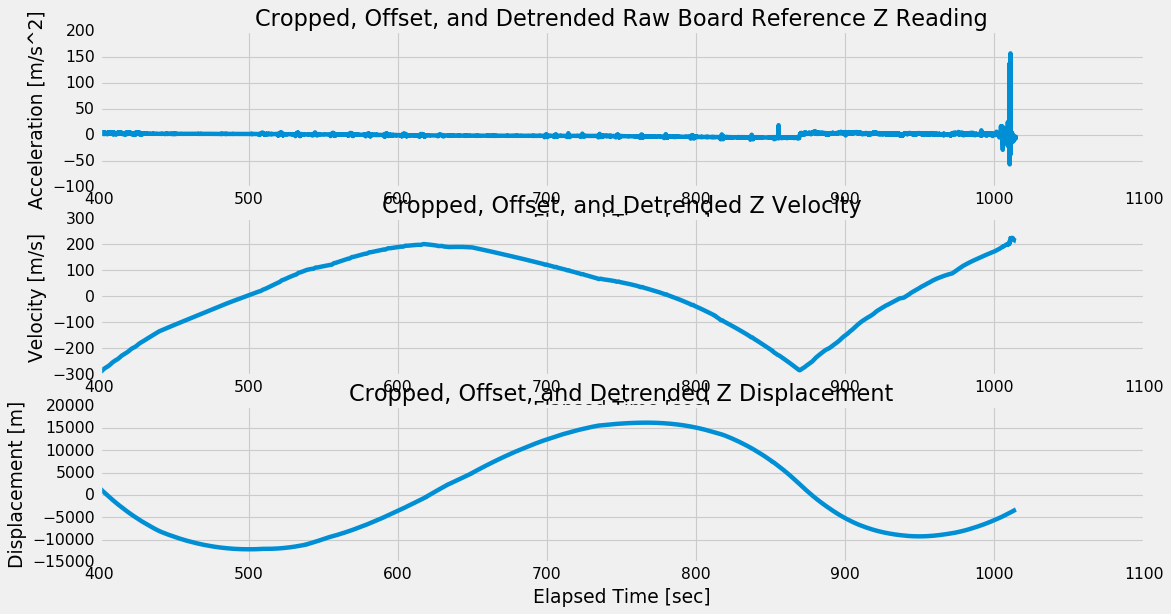

In [62]:
z_acc_cropped_trend = signal.detrend(z_acc_cropped)

#z_acc_cropped_trend_off = z_acc_cropped_trend + 9.806

z_vel_cropped = scipy.integrate.cumtrapz(z_acc_cropped_trend, time_cropped)
print(len(z_vel_cropped), len(time_cropped))
z_vel_cropped = np.append(z_vel_cropped, z_vel_cropped[len(z_vel_cropped)-1])
z_vel_cropped_trend = signal.detrend(z_vel_cropped)
z_disp_cropped = scipy.integrate.cumtrapz(z_vel_cropped_trend, time_cropped)
z_disp_cropped = np.append(z_disp_cropped, z_disp_cropped[len(z_disp_cropped)-1])
z_disp_cropped_trend = signal.detrend(z_disp_cropped)
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.plot(time_cropped, z_acc_cropped_trend)
ax1.set_title('Cropped, Offset, and Detrended Raw Board Reference Z Reading')
ax1.set_xlabel('Elapsed Time [sec]')
ax1.set_ylabel('Acceleration [m/s^2]')

ax2.plot(time_cropped, z_vel_cropped_trend)
ax2.set_title('Cropped, Offset, and Detrended Z Velocity')
ax2.set_xlabel('Elapsed Time [sec]')
ax2.set_ylabel('Velocity [m/s]')

ax3.plot(time_cropped, z_disp_cropped_trend)
ax3.set_title('Cropped, Offset, and Detrended Z Displacement')
ax3.set_xlabel('Elapsed Time [sec]')
ax3.set_ylabel('Displacement [m]')

plt.show()